## **Problem Statement**

**DOMAIN:** Industrial safety. NLP based Chatbot.

**CONTEXT:** The  database  comes  from one  of  the  biggest  industry  in  Brazil  and  in  the  world.  It  is  an  urgent  need  for  industries/companies  around  the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.

**DATA DESCRIPTION:** This  The  database  is  basically  records  of  accidents  from 12  different  plants  in  03  different  countries which  every  line  in  the  data  is  an occurrence of an accident.

  **Columns description:**
   - Data: timestamp or time/date information
   - Countries: which country the accident occurred (anonymised)
   - Local: the city where the manufacturing plant is located (anonymised)
   - Industry sector: which sector the plant belongs to
   - Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
   - Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)
   - Genre: if the person is male of female
   - Employee or Third Party: if the injured person is an employee or a third party
   - Critical Risk: some description of the risk involved in the accident
   - Description: Detailed description of how the accident happened.

**PROJECT OBJECTIVE:** Design  a  ML/DL  based  chatbot  utility  which  can  help  the  professionals  to  highlight  the  safety  risk  as  per  the  incident description.

## **Importing the necessary libraries**

In [177]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to use regular expressions for manipulating text data
import re

# Importing the SpaCy library
import spacy
nlp = spacy.load('en_core_web_sm')    # loading the envrionment config

# To create Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# To create TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# To plot confusion matrices
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import io, base64
from IPython.display import HTML, display

# To use various metrics from sklearn
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# To visualize data

import holoviews as holoviews
from holoviews import opts
from sklearn.feature_selection import chi2



## **Loading the dataset**

In [178]:
# Mount the google drive
from google.colab import drive
try:
  drive.mount('/content/drive') # Mounts your Google Drive
except Exception as e:
  print(f"Error mounting Google Drive: {e}")
  print("Please try running the cell again. If the error persists, you may need to re-authenticate your Google account.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [179]:
# loading data into a pandas dataframe
#accidents_data = pd.read_excel("/content/industrial_safety_and_health_database_with_accidents_description.xlsx")
accidents_data = pd.read_excel("https://raw.githubusercontent.com/ABHINAVRISHI1983/nlp-chat-bot/main/industrial_safety_and_health_database_with_accidents_description.xlsx", engine='openpyxl')

In [180]:
# creating a copy of the data
data = accidents_data.copy() #Good practice to preserve raw data

## **Data Overview**

### Checking the first five rows of the data

In [5]:
# Display top 5 rows
data.head(5)

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo."
1,1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter."
2,2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,"In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury."
3,3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,"Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the ""DADO"" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury."
4,4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,"Approximately at 11:45 a.m. in circumstances that the mechanics Anthony (group leader), Eduardo and Eric Fernández-injured-the three of the Company IMPROMEC, performed the removal of the pulley of the motor of the pump 3015 in the ZAF of Marcy. 27 cm / Length: 33 cm / Weight: 70 kg), as it was locked proceed to heating the pulley to loosen it, it comes out and falls from a distance of 1.06 meters high and hits the instep of the right foot of the worker, causing the injury described."


In [7]:
# Drop unnamed cols as it seems more like index or S.No
data.drop(columns=[col for col in data.columns if "Unnamed" in col], inplace=True)

In [6]:
# Display top 5 rows after dropping
data.head(5)

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo."
1,1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter."
2,2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,"In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury."
3,3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,"Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the ""DADO"" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury."
4,4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,"Approximately at 11:45 a.m. in circumstances that the mechanics Anthony (group leader), Eduardo and Eric Fernández-injured-the three of the Company IMPROMEC, performed the removal of the pulley of the motor of the pump 3015 in the ZAF of Marcy. 27 cm / Length: 33 cm / Weight: 70 kg), as it was locked proceed to heating the pulley to loosen it, it comes out and falls from a distance of 1.06 meters high and hits the instep of the right foot of the worker, causing the injury described."


- All records in the Description column are detailed and natural language-based.
- Potential Accident Level - ordinal classification target, looks like it is ranging from I to IV
- Critical Risk - could be multi-class or multi-label target.
-Countries, Local, Industry Sector, Genre, Employee or Third Party, Critical Risk Have limited number of categories, Could be one-hot encoded or embedded later


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Data                      425 non-null    datetime64[ns]
 1   Countries                 425 non-null    object        
 2   Local                     425 non-null    object        
 3   Industry Sector           425 non-null    object        
 4   Accident Level            425 non-null    object        
 5   Potential Accident Level  425 non-null    object        
 6   Genre                     425 non-null    object        
 7   Employee or Third Party   425 non-null    object        
 8   Critical Risk             425 non-null    object        
 9   Description               425 non-null    object        
dtypes: datetime64[ns](1), object(9)
memory usage: 33.3+ KB


- Data is datetime column
- All other columns are of type Object
- Countries, Local, Industry Sector are Categorical columns used for Geographic distribution of accidents, Industry-wise accident risk profiling
- Accident Level is Target candidate
- Genre is Likely binary (Male, Female)
- Employee or Third Party is categorical with values "Employee", "Third Party", "Third Party (Remote)"
- Critical Risk is Multi-class categorical that represents accident cause or risk factor
- Description is original accident text (rich, unstructured), can be used for NLP and Risk pattern mining

In [9]:
data['Accident Level'].value_counts()

,count
Accident Level,
I,316
II,40
III,31
IV,30
V,8


- There are 6 Accident levels

In [10]:
data['Description'].str.len().describe()

,Description
count,425.000000
mean,368.280000
std,178.944426
min,94.000000
25%,227.000000
50%,335.000000
75%,457.000000
max,1029.000000


- On average, each description is about 365 characters long
- Some are very short, some quite long with min being 94 chars and max being 1029 chars
- 25% of descriptions are shorter than 225 characters
- Median length is 334 characters — close to the mean
- 75% of the descriptions are under 453 characters
- The longest description is over 1000 characters (very detailed)

### Checking the shape of the dataset

In [11]:
#check shape of dataset
data.shape

(425, 10)

* The dataset has 425 rows and 10 columns.

### Checking for Missing Values

In [12]:
#check for missing values
data.isnull().sum()

,0
Data,0
Countries,0
Local,0
Industry Sector,0
Accident Level,0
Potential Accident Level,0
Genre,0
Employee or Third Party,0
Critical Risk,0
Description,0


* There are no missing values in the data

### Checking for duplicate values

In [ ]:
# checking for duplicate values
data.duplicated().sum()

- There are 7 duplicate rows

In [ ]:
# Drop duplicate rows
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [ ]:
# Confirm removal
print(f"Duplicates in current dataset - {data.duplicated().sum()}")
print(f"New shape after removing duplicates: {data.shape}")

* The dataset has 418 rows and 10 columns after dropping the duplicates

## **Data Preprocessing**

### **Removing special characters**

In [158]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = re.sub(pattern, ' ', text)

    return new_text

In [159]:
# Applying the function to remove special characters
data['cleaned_text'] = data['Description'].apply(remove_special_characters)

In [160]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['Description','cleaned_text']]

,Description,cleaned_text
0,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.",While removing the drill rod of the Jumbo 08 for maintenance the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo
1,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.",During the activation of a sodium sulphide pump the piping was uncoupled and the sulfide solution was designed in the area to reach the maid Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital Note of sulphide solution 48 grams liter
2,"In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury.",In the sub station MILPO located at level 170 when the collaborator was doing the excavation work with a pick hand tool hitting a rock with the flat part of the beak it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of the left foot of the collaborator causing the injury
3,"Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the ""DADO"" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury.",Being 9 45 am approximately in the Nv 1880 CX 695 OB7 the personnel begins the task of unlocking the Soquet bolts of the BHB machine when they were in the penultimate bolt they identified that the hexagonal head was worn proceeding Mr Crist bal Auxiliary assistant to climb to the platform to exert pressure with your hand on the DADO key to prevent it from coming out of the bolt in those moments two collaborators rotate with the lever in anti clockwise direction leaving the key of the bolt hitting the palm of the left hand causing the injury


- We can observe that regex removed the special characters ilike comma (,), equals (=), slash (/), Hiphen (-) etc.,

### **Lowercasing**

In [161]:
# changing the case of the text data to lower case
data['cleaned_text'] = data['cleaned_text'].str.lower()

In [162]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['Description','cleaned_text']]

,Description,cleaned_text
0,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.",while removing the drill rod of the jumbo 08 for maintenance the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo
1,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.",during the activation of a sodium sulphide pump the piping was uncoupled and the sulfide solution was designed in the area to reach the maid immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital note of sulphide solution 48 grams liter
2,"In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury.",in the sub station milpo located at level 170 when the collaborator was doing the excavation work with a pick hand tool hitting a rock with the flat part of the beak it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of the left foot of the collaborator causing the injury
3,"Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the ""DADO"" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury.",being 9 45 am approximately in the nv 1880 cx 695 ob7 the personnel begins the task of unlocking the soquet bolts of the bhb machine when they were in the penultimate bolt they identified that the hexagonal head was worn proceeding mr crist bal auxiliary assistant to climb to the platform to exert pressure with your hand on the dado key to prevent it from coming out of the bolt in those moments two collaborators rotate with the lever in anti clockwise direction leaving the key of the bolt hitting the palm of the left hand causing the injury


- We can observe that all the text has now successfully been converted to lower case.

### **Removing extra whitespace**

In [163]:
# Count rows with 2+ consecutive spaces
data['Description'].apply(lambda x: bool(re.search(r'\s{2,}', str(x)))).sum()

np.int64(0)

- There are no extra spaces found, so no need to strip the spaces, still better to have the step for any future data

In [164]:
# removing extra whitespaces from the text
data['cleaned_text'] = data['cleaned_text'].str.strip()

### **Lemmatization**

In [165]:
def spacy_lemmatize(text):
    doc = nlp(text)
    return ' '.join([
        token.lemma_ for token in doc
        if not token.is_punct and not token.is_space and not token.is_stop
    ])

In [166]:
# Apply on cleaned_text (not the one with stopwords already removed)
data['final_cleaned_text'] = data['cleaned_text'].apply(spacy_lemmatize)

In [167]:
# checking a couple of instances of cleaned data
data.loc[0:2, ['Description', 'cleaned_text', 'final_cleaned_text']]


,Description,cleaned_text,final_cleaned_text
0,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.",while removing the drill rod of the jumbo 08 for maintenance the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo,remove drill rod jumbo 08 maintenance supervisor proceed loosen support intermediate centralizer facilitate removal see mechanic support end drill equipment pull hand bar accelerate removal moment bar slide point support tighten finger mechanic drilling bar beam jumbo
1,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.",during the activation of a sodium sulphide pump the piping was uncoupled and the sulfide solution was designed in the area to reach the maid immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital note of sulphide solution 48 grams liter,activation sodium sulphide pump piping uncoupled sulfide solution design area reach maid immediately use emergency shower direct ambulatory doctor later hospital note sulphide solution 48 gram liter
2,"In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury.",in the sub station milpo located at level 170 when the collaborator was doing the excavation work with a pick hand tool hitting a rock with the flat part of the beak it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of the left foot of the collaborator causing the injury,sub station milpo locate level 170 collaborator excavation work pick hand tool hit rock flat beak bounce hit steel tip safety shoe metatarsal area left foot collaborator cause injury


We can see that the below sample words and corresponding word after applying lemmatization, This look much better that porter stemming

- removing -> remove
- proceeds -> proceed
- seeing -> see
- supports -> support

##**EDA**

In [181]:
#Create a copy for EDA analysis
data_eda=data.copy()


In [22]:
# Function to Derive Season based on Month
def convertMonthToSeason(x):
    if x in [9, 10, 11]:
        season = 'Spring'
    elif x in [12, 1, 2]:
        season = 'Summer'
    elif x in [3, 4, 5]:
        season = 'Autumn'
    elif x in [6, 7, 8]:
        season = 'Winter'
    return season


### **Extract Day/Month/Year/Season/WeekDay/WeekofYear from the Data**

In [183]:
data_eda['Year'] = data_eda.Data.apply(lambda x : x.year).astype(int)
data_eda['Month'] = data_eda.Data.apply(lambda x : x.month_name())
data_eda['Month_Number'] = data_eda.Data.apply(lambda x : x.month)
data_eda['Day'] = data_eda.Data.apply(lambda x : x.day)
data_eda['Weekday'] = data_eda.Data.apply(lambda x : x.day_name())
data_eda['WeekofYear'] = data_eda.Data.apply(lambda x : x.weekofyear)
data_eda["DayOfWeek"] = data_eda["Data"].dt.day_name()
data_eda['Season'] = data_eda['Month_Number'].apply(convertMonthToSeason)


###**Univariate Analysis**

####**Industry Sector**

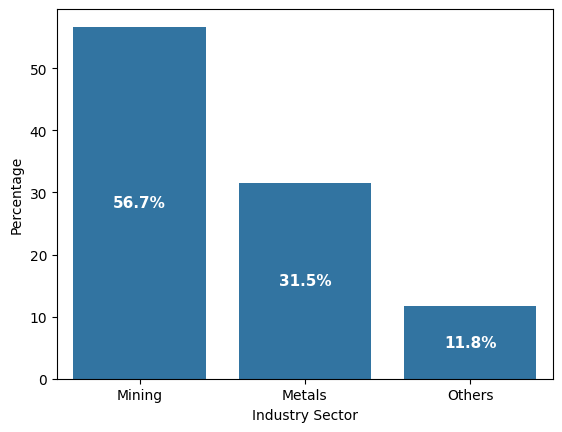

In [125]:
ax = sns.countplot(data=data_eda, x="Industry Sector", stat="percent")
plt.ylabel("Percentage")
plt.xlabel("Industry Sector")
# Add percentage labels inside bars
for p in ax.patches:
    percentage = f'{p.get_height():.1f}%'  # format with 1 decimal
    ax.text(
        p.get_x() + p.get_width() / 2.,  # x-position (center of bar)
        p.get_height() / 2.,             # y-position (middle of bar)
        percentage,
        ha='center', va='center', color='white', fontsize=11, fontweight='bold'
    )

plt.show();

**Observation:**

*  Mining industry has highest percentage of accidents which is 56.7 %.
*  Metals has 30.6% accidents.
*  Others  has 10.4% of accidents.

####**Country**

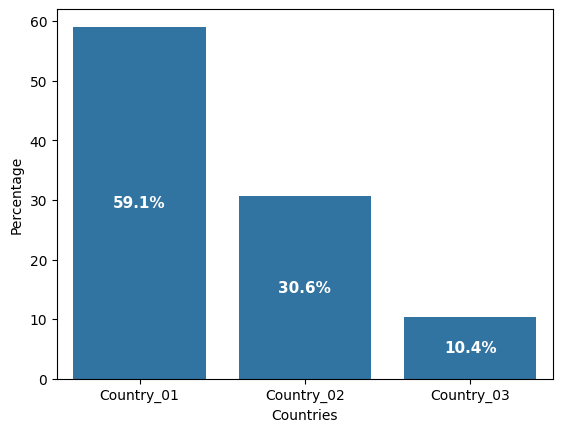

In [126]:
ax = sns.countplot(data=data, x="Countries", stat="percent")
plt.ylabel("Percentage")
plt.xlabel("Countries")
# Add percentage labels inside bars
for p in ax.patches:
    percentage = f'{p.get_height():.1f}%'  # format with 1 decimal
    ax.text(
        p.get_x() + p.get_width() / 2.,  # x-position (center of bar)
        p.get_height() / 2.,             # y-position (middle of bar)
        percentage,
        ha='center', va='center', color='white', fontsize=11, fontweight='bold'
    )

plt.show();

**Observation:**

- Country_01 has highest percentage of accidents which is 59.1 %.
- Country_02 has 30.6% accidents.
- Country_03 has 10.4% of accidents.


####**Local**

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
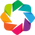

:Bars   [Local]   (proportion)

In [131]:
local_cnt = np.round(data_eda['Local'].value_counts(normalize=True) * 100)

holoviews.extension('bokeh')
holoviews.Bars(local_cnt).opts(title="Local Count", color="#8888ff", xlabel="Locals", ylabel="Percentage", yformatter='%d%%')\
                .opts(opts.Bars(width=1000, height=300,tools=['hover'],show_grid=True))

**Observation:**

* Local_03 has highest number of accidents.

####**Genre**

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
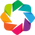

:Bars   [Genre]   (proportion)

In [135]:
local_cnt = np.round(data_eda['Genre'].value_counts(normalize=True) * 100)
holoviews.extension('bokeh')
holoviews.Bars(local_cnt).opts(title="Genre Count", color="#8888ff", xlabel="Genre", ylabel="Percentage", yformatter='%d%%')\
                .opts(opts.Bars(width=1000, height=300,tools=['hover'],show_grid=True))

**Observation:**

* Accidents are disproportionately higher among males compared to females.

####**Employee or Third Party**

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
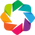

:Bars   [Employee or Third Party]   (proportion)

In [147]:
local_cnt = np.round(data_eda['Employee or Third Party'].value_counts(normalize=True) * 100)
holoviews.extension('bokeh')
holoviews.Bars(local_cnt).opts(title="Employee Type Count", color="#8888ff", xlabel="Employee Type", ylabel="Percentage", yformatter='%d%%')\
                .opts(opts.Bars(width=500, height=600,tools=['hover'],show_grid=True))

**Observation:**
* There is not much of a difference between Third Party workers and Employees in the incident report.

####**Critical Risk**

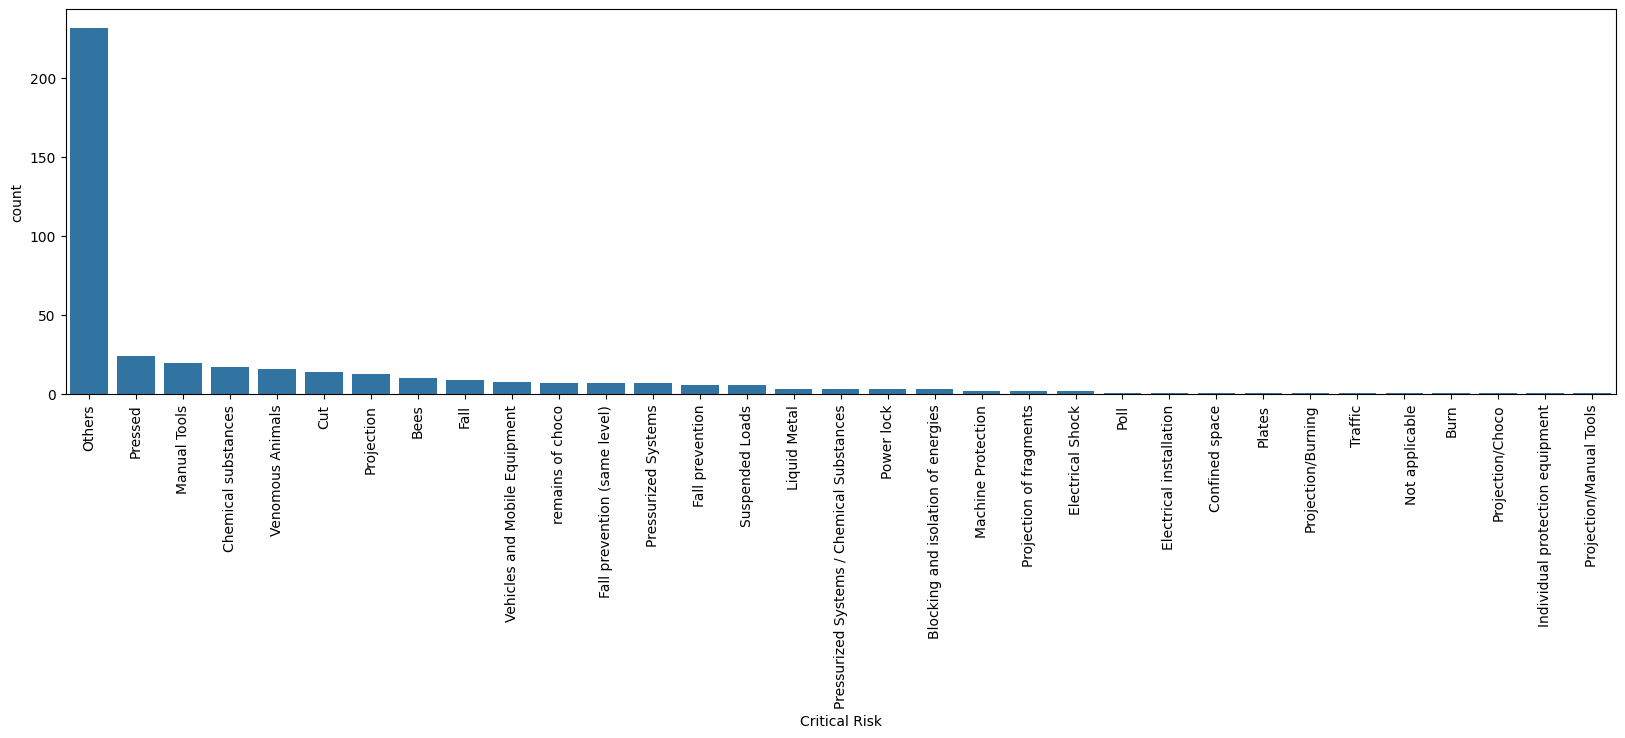

In [35]:
plt.figure(figsize=(20,5))
descending_order = data_eda['Critical Risk'].value_counts().sort_values(ascending=False).index
sns.countplot(x=data_eda['Critical Risk'],order=descending_order)
plt.xticks(rotation = 'vertical')
plt.show()


**Observation:**

* 'Others’ category has the most entries, indicating that the critical-risk taxonomy and reporting process are inadequate—most on-site incidents don’t fit the current categories
* Ater Others,Pressed/Manual Tools/Chemical Substances are top 3 critical Risk.

####**Data**

In [136]:
# build counts
df_year = (data_eda["Data"].dt.year
           .value_counts()
           .sort_index()
           .rename_axis("Year")
           .reset_index(name="Count"))

# make Year a *categorical* (ordered) so axis shows 2016, 2017, ... (no decimals)
df_year["Year"] = pd.Categorical(
    df_year["Year"].astype(str),              # strings => discrete axis
    categories=df_year["Year"].astype(str).tolist(),
    ordered=True
)

by_year = holoviews.Bars(
    df_year, kdims="Year", vdims='Count'
).opts(
    title="By Year", xlabel="Year", ylabel="Count",
    width=420, height=300, show_grid=True, color="#1f77b4"
)

# Month order
months = ["January","February","March","April","May","June",
          "July","August","September","October","November","December"]

df_month = (data_eda["Data"].dt.month_name()
            .value_counts()
            .reindex(months, fill_value=0)
            .rename_axis("Month")
            .reset_index(name="Count"))

# Make categorical with explicit order
df_month["Month"] = pd.Categorical(df_month["Month"], categories=months, ordered=True)

by_month = holoviews.Bars(
    df_month, kdims="Month", vdims="Count"
).opts(
    title="By Month",
    xlabel="Month", ylabel="Count",
    width=600, height=300, xrotation=45,
    show_grid=True, color="#2ca02c"
)
# Weekday order
weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

df_dow = (data_eda["Data"].dt.day_name()
          .value_counts()
          .reindex(weekdays, fill_value=0)
          .rename_axis("Day")
          .reset_index(name="Count"))

df_dow["Day"] = pd.Categorical(df_dow["Day"], categories=weekdays, ordered=True)

by_dow = holoviews.Bars(
    df_dow, kdims="Day", vdims="Count"
).opts(
    title="By Day of Week",
    xlabel="Day", ylabel="Count",
    width=600, height=300,
    show_grid=True, color="#ff7f0e"
)

(by_year + by_month + by_dow).cols(3)

:Layout
   .Bars.I   :Bars   [Year]   (Count)
   .Bars.II  :Bars   [Month]   (Count)
   .Bars.III :Bars   [Day]   (Count)

**Observation:**

**By Year** → Most incidents occurred in 2016, with a drop in 2017.

**By Month** → Incidents are fairly spread across months, with peak in February and higher overall in 1st half of the year

**By Day of Week** → Incidents occur throughout the week, slightly higher on Thursdays.

####**Weekly Incidents**

Text(0, 0.5, 'Count')

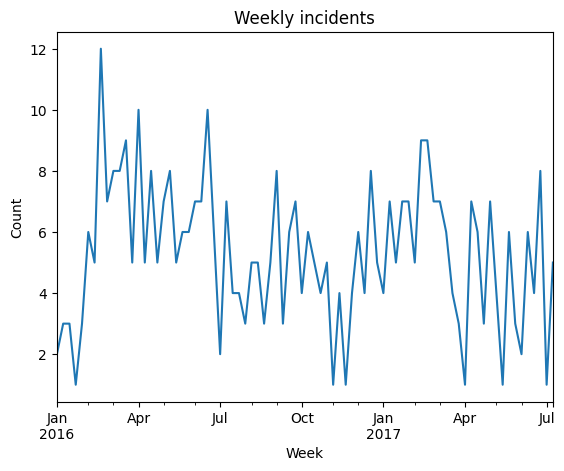

In [137]:
ax = (data_eda.set_index('Data')
           .resample('W').size()              # weekly row count
           .rename('Incidents per week')
           .plot())

ax.set_title('Weekly incidents')
ax.set_xlabel('Week')
ax.set_ylabel('Count')

**Observation:**

* Counts fluctuate a lot week to week (mostly 2–8), with a few spikes to 10–12.

* No clear upward or downward trend across 2016–mid-2017.

* Clusters of higher activity appear in early 2016 and early 2017.

* Quieter periods around late 2016 and Apr–May 2017.

####**Accident level by Season**

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
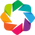

:Layout
   .Overlay.I  :Overlay
      .Curve.I   :Curve   [Season]   (I)
      .Curve.II  :Curve   [Season]   (II)
      .Curve.III :Curve   [Season]   (III)
      .Curve.IV  :Curve   [Season]   (IV)
      .Curve.V   :Curve   [Season]   (V)
   .Overlay.II :Overlay
      .Curve.I   :Curve   [Season]   (I)
      .Curve.II  :Curve   [Season]   (II)
      .Curve.III :Curve   [Season]   (III)
      .Curve.IV  :Curve   [Season]   (IV)
      .Curve.V   :Curve   [Season]   (V)
      .Curve.VI  :Curve   [Season]   (VI)

In [184]:
f = lambda x : np.round(x/x.sum() * 100)
ac_season = data_eda.groupby(['Season','Accident Level'])['Accident Level'].count().unstack().apply(f, axis=1).fillna(0)
ac_season['season_num'] = [['Spring', 'Summer', 'Autumn', 'Winter'].index(i) for i in ac_season.index]
ac_season.sort_values('season_num', inplace=True)
ac_season.drop('season_num', axis=1, inplace=True)

# Ensure bokeh extension is active before plotting curves
holoviews.extension('bokeh')

ac = holoviews.Curve(ac_season['I'], label='I') * holoviews.Curve(ac_season['II'], label='II') * holoviews.Curve(ac_season['III'], label='III') * holoviews.Curve(ac_season['IV'], label='IV') * holoviews.Curve(ac_season['V'], label='V')\
        .opts(opts.Curve(title="Accident Level by Season Count"))
pot_ac_season = data_eda.groupby(['Season','Potential Accident Level'])['Potential Accident Level'].count().unstack().apply(f, axis=0).fillna(0)
pot_ac_season['season_num'] = [['Spring', 'Summer', 'Autumn', 'Winter'].index(i) for i in pot_ac_season.index]
pot_ac_season.sort_values('season_num', inplace=True)
pot_ac_season.drop('season_num', axis=1, inplace=True)
pot_ac = holoviews.Curve(pot_ac_season['I'], label='I') * holoviews.Curve(pot_ac_season['II'], label='II') * holoviews.Curve(pot_ac_season['III'], label='III') * holoviews.Curve(pot_ac_season['IV'], label='IV')\
        * holoviews.Curve(pot_ac_season['V'], label='V') * holoviews.Curve(pot_ac_season['VI'], label='VI').opts(opts.Curve(title="Potential Accident Level by Season Count"))
(ac+pot_ac).opts(opts.Curve(width=1000, height=500,tools=['hover'],show_grid=True, ylabel="Percentage", yformatter='%d%%')).cols(1)

**Observation:**

* Actual accidents remain mostly low-level (Level I) year-round.

* However, the potential severity risk is seasonal, highest in Summer (Level II surge) and Autumn (spread across Levels III–V).

* This gap highlights that preventive measures should be especially strengthened in Summer and Autumn to avoid escalation of potential severe incidents.

###**Bivariate Analysis**

####**Industry wise  Accident Level and Potential Accident level**


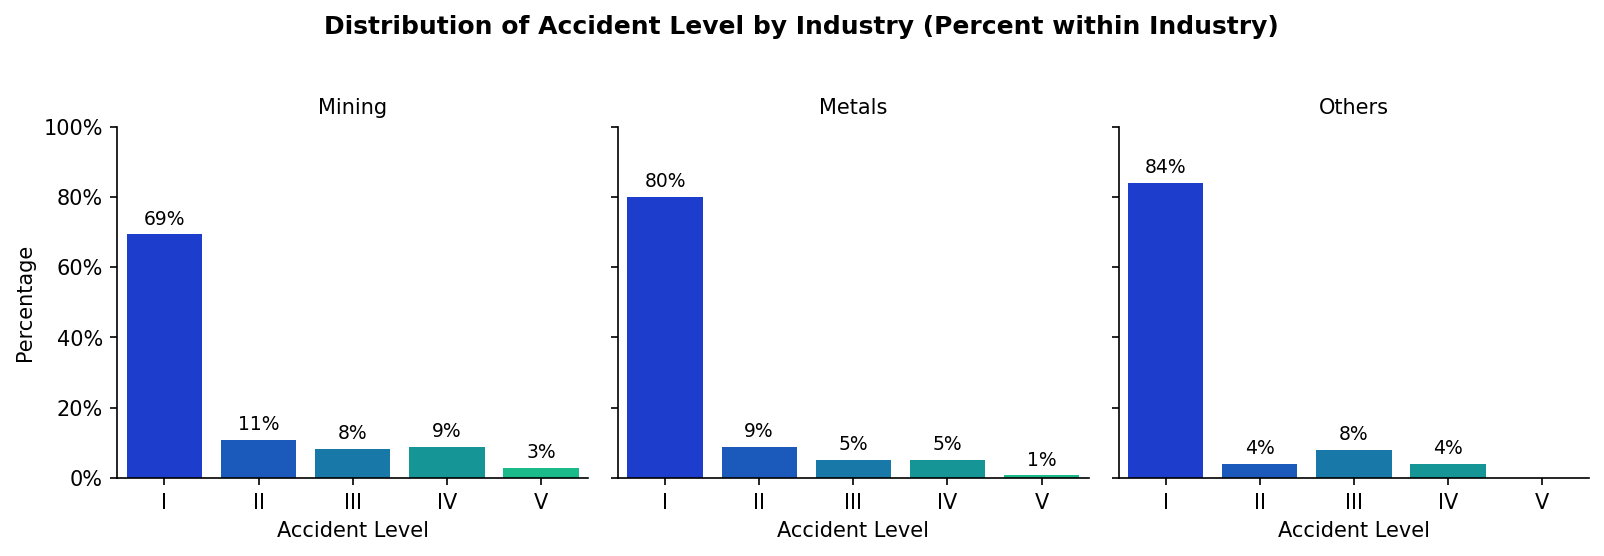
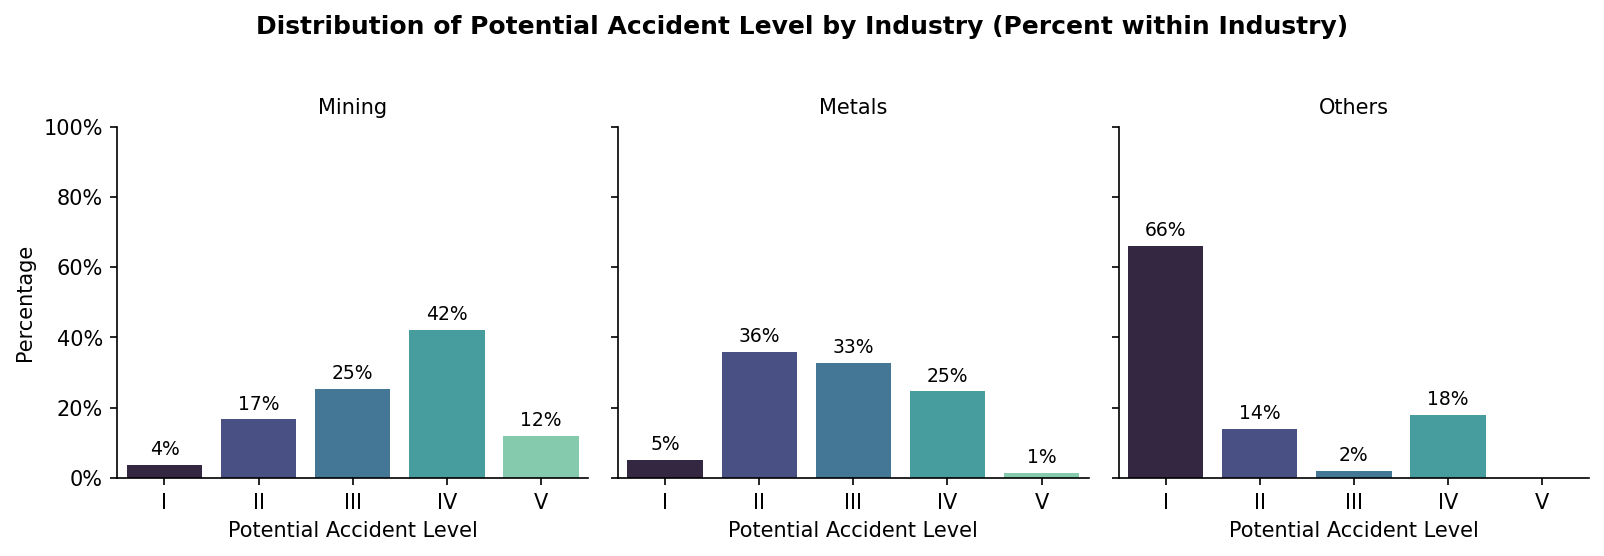

In [149]:
# === Side-by-Side Facets: Accident Level vs Potential Accident Level
#     (percentage within each industry) ===

# ---------- Config ----------
level_order = ['I', 'II', 'III', 'IV', 'V']   # desired order on x-axis
facet_col_wrap = 3                            # how many panels per row
facet_height = 3.6                            # per-panel height (inches)

# ---------- Prepare data ----------
df = data.copy()  # assumes `data` DataFrame already exists
df['Accident Level'] = pd.Categorical(df['Accident Level'],
                                      categories=level_order, ordered=True)
df['Potential Accident Level'] = pd.Categorical(df['Potential Accident Level'],
                                                categories=level_order, ordered=True)

# All industries list for complete grids (so missing levels show as 0%)
industries = df['Industry Sector'].dropna().unique()
idx_acc = pd.MultiIndex.from_product([industries, level_order],
                                     names=['Industry Sector', 'Accident Level'])
idx_pot = pd.MultiIndex.from_product([industries, level_order],
                                     names=['Industry Sector', 'Potential Accident Level'])

# ---------- Build percentage tables ----------
# Accident Level
counts_acc = (
    df.groupby(['Industry Sector', 'Accident Level'], observed=False)
      .size()
      .reindex(idx_acc, fill_value=0)
      .reset_index(name='n')
)
counts_acc['pct'] = (
    counts_acc['n'] /
    counts_acc.groupby('Industry Sector')['n'].transform('sum').replace(0, 1)
)

# Potential Accident Level
counts_pot = (
    df.groupby(['Industry Sector', 'Potential Accident Level'], observed=False)
      .size()
      .reindex(idx_pot, fill_value=0)
      .reset_index(name='n')
)
counts_pot['pct'] = (
    counts_pot['n'] /
    counts_pot.groupby('Industry Sector')['n'].transform('sum').replace(0, 1)
)

# ---------- Helper to draw a FacetGrid with % bars and labels ----------
def draw_facet_percentage(df_in, x_col, x_label, title, palette):
    g = sns.FacetGrid(
        df_in, col='Industry Sector', col_wrap=facet_col_wrap,
        height=facet_height, sharey=True, legend_out=True
    )
    g.map_dataframe(
        sns.barplot,
        x=x_col, y='pct',
        order=level_order,
        hue=x_col, hue_order=level_order,
        palette=palette, dodge=False, errorbar=None
    )
    g.set_titles("{col_name}")
    g.set_axis_labels(x_label, "Percentage")
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax.set_ylim(0, 1)
        # % labels on bars
        for p in ax.patches:
            h = p.get_height()
            if h > 0:
                ax.annotate(f"{h*100:.0f}%", (p.get_x() + p.get_width()/2, h),
                            ha="center", va="bottom", fontsize=9, xytext=(0, 3),
                            textcoords="offset points")
    # one shared legend
    handles, labels = g.axes.flat[0].get_legend_handles_labels()
    if handles:
        g.fig.legend(handles, labels, title=x_label,
                     loc="center left", bbox_to_anchor=(1.02, 0.5))
    g.fig.suptitle(title, y=1.02, fontsize=12, fontweight="bold")
    g.tight_layout()
    return g.fig

# ---------- Draw the two figures (Accident vs Potential) ----------
plt.close('all')

fig_acc = draw_facet_percentage(
    counts_acc, x_col='Accident Level', x_label='Accident Level',
    title='Distribution of Accident Level by Industry (Percent within Industry)',
    palette='winter'
)

fig_pot = draw_facet_percentage(
    counts_pot, x_col='Potential Accident Level', x_label='Potential Accident Level',
    title='Distribution of Potential Accident Level by Industry (Percent within Industry)',
    palette='mako'
)

# ---------- Save both figures to base64 and show side-by-side, centered ----------
def fig_to_base64(fig, dpi=150):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", dpi=dpi)
    plt.close(fig)  # prevent duplicate auto-render in notebooks
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode("utf-8")
    buf.close()
    return b64

b64_acc = fig_to_base64(fig_acc, dpi=150)
b64_pot = fig_to_base64(fig_pot, dpi=150)

display(HTML(f"""
<div style="display:flex; justify-content:center; gap:16px; margin:16px 0; align-items:flex-start; flex-wrap:wrap;">
  <img src="data:image/png;base64,{b64_acc}" style="width:48%; min-width:500px; height:auto;" />
  <img src="data:image/png;base64,{b64_pot}" style="width:48%; min-width:500px; height:auto;" />
</div>
"""))


**Observation:**

 **Accident Level (actual incidents):**
 *  Most events are minor (Level I) across all areas.
 * **Mining** stands out with more Level II–III than any other industry.
 * **Metals** has some mid-severity; Others is mostly minor.

 **Potential Accident Level:**
 * If things go wrong, **Mining** could escalate to higher severity (III–IV);
 * **Metals** trends medium; Others stays low.


####**Country  wise  Accident Level and Potential Accident level**


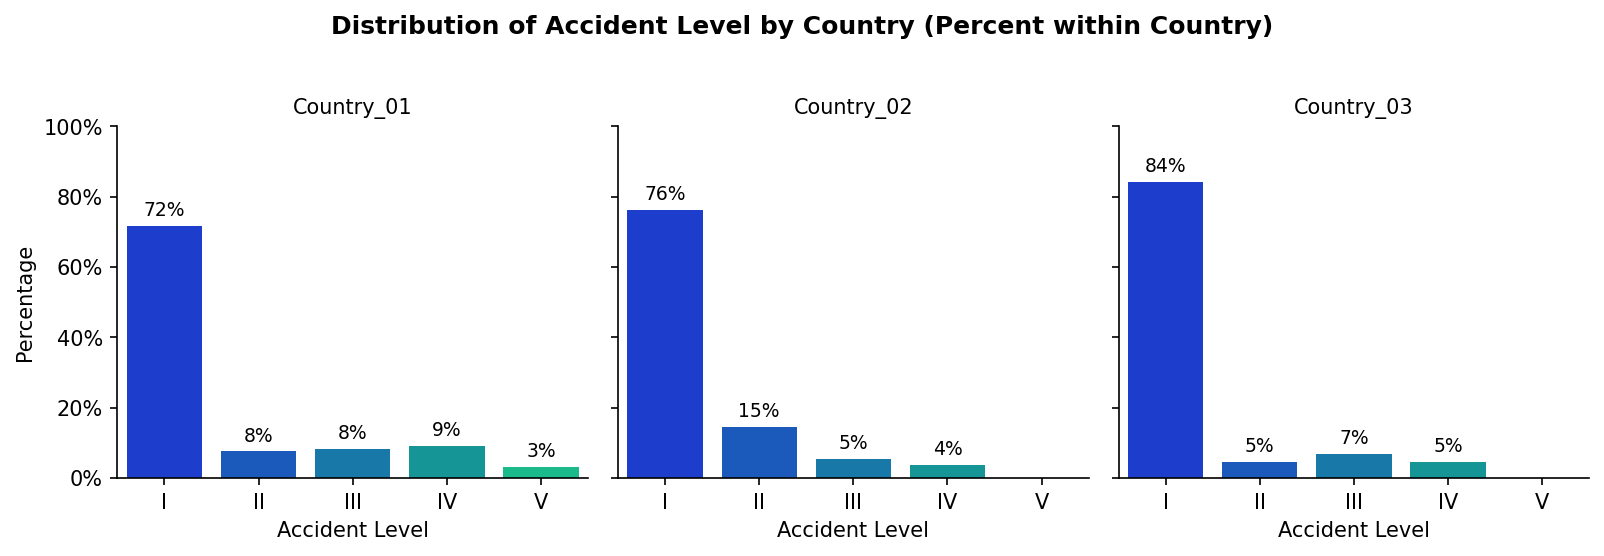
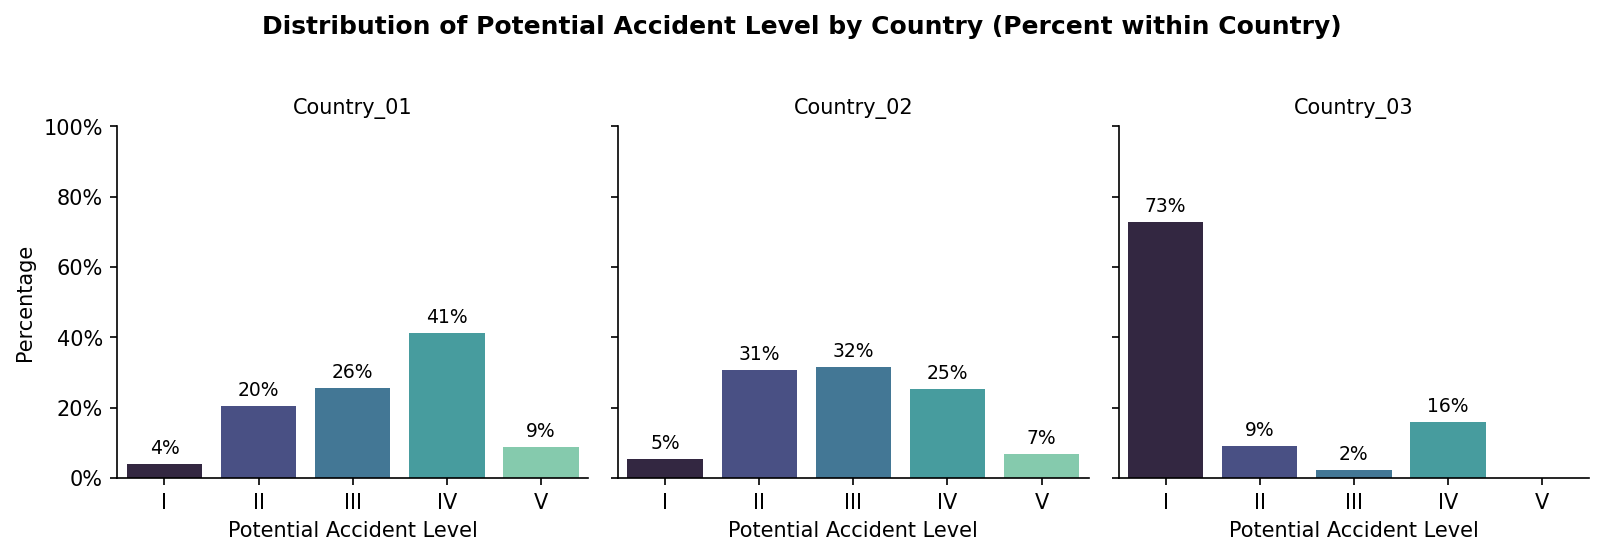

In [150]:
# === Side-by-Side Facets: Accident Level vs Potential Accident Level
#     (percentage within each country) ===

# ---------- Config ----------
level_order   = ['I', 'II', 'III', 'IV', 'V']   # x-axis order for levels
facet_col_wrap = 3                               # panels per row
facet_height   = 3.6                             # panel height (inches)

# ---------- Prepare data ----------
df = data.copy()  # assumes `data` DataFrame exists with columns: Countries, Accident Level, Potential Accident Level
df['Accident Level']           = pd.Categorical(df['Accident Level'],           categories=level_order, ordered=True)
df['Potential Accident Level'] = pd.Categorical(df['Potential Accident Level'], categories=level_order, ordered=True)

# Build complete grids so missing levels show as 0%
countries = df['Countries'].dropna().unique()
idx_acc = pd.MultiIndex.from_product([countries, level_order], names=['Countries', 'Accident Level'])
idx_pot = pd.MultiIndex.from_product([countries, level_order], names=['Countries', 'Potential Accident Level'])

# ---------- Build percentage tables ----------
# Accident Level
counts_acc = (
    df.groupby(['Countries', 'Accident Level'], observed=False)
      .size()
      .reindex(idx_acc, fill_value=0)
      .reset_index(name='n')
)
counts_acc['pct'] = counts_acc['n'] / counts_acc.groupby('Countries')['n'].transform('sum').replace(0, 1)

# Potential Accident Level
counts_pot = (
    df.groupby(['Countries', 'Potential Accident Level'], observed=False)
      .size()
      .reindex(idx_pot, fill_value=0)
      .reset_index(name='n')
)
counts_pot['pct'] = counts_pot['n'] / counts_pot.groupby('Countries')['n'].transform('sum').replace(0, 1)

# ---------- Helper to draw a FacetGrid with % bars and labels ----------
def draw_facet_percentage(df_in, facet_col, x_col, x_label, title, palette):
    g = sns.FacetGrid(
        df_in, col=facet_col, col_wrap=facet_col_wrap,
        height=facet_height, sharey=True, legend_out=True
    )
    g.map_dataframe(
        sns.barplot,
        x=x_col, y='pct',
        order=level_order,
        hue=x_col, hue_order=level_order,
        palette=palette, dodge=False, errorbar=None  # seaborn ≥0.13
    )
    g.set_titles("{col_name}")
    g.set_axis_labels(x_label, "Percentage")
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax.set_ylim(0, 1)
        # % labels on bars
        for p in ax.patches:
            h = p.get_height()
            if h > 0:
                ax.annotate(f"{h*100:.0f}%", (p.get_x() + p.get_width()/2, h),
                            ha="center", va="bottom", fontsize=9, xytext=(0, 3),
                            textcoords="offset points")
    # one shared legend
    handles, labels = g.axes.flat[0].get_legend_handles_labels()
    if handles:
        g.fig.legend(handles, labels, title=x_label,
                     loc="center left", bbox_to_anchor=(1.02, 0.5))
    g.fig.suptitle(title, y=1.02, fontsize=12, fontweight="bold")
    g.tight_layout()
    return g.fig

# ---------- Draw the two figures (Accident vs Potential) ----------
plt.close('all')

fig_acc = draw_facet_percentage(
    counts_acc, facet_col='Countries',
    x_col='Accident Level', x_label='Accident Level',
    title='Distribution of Accident Level by Country (Percent within Country)',
    palette='winter'
)

fig_pot = draw_facet_percentage(
    counts_pot, facet_col='Countries',
    x_col='Potential Accident Level', x_label='Potential Accident Level',
    title='Distribution of Potential Accident Level by Country (Percent within Country)',
    palette='mako'
)

# ---------- Save both figures to base64 and show side-by-side, centered ----------
def fig_to_base64(fig, dpi=150):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", dpi=dpi)
    plt.close(fig)  # prevent duplicate auto-render
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode("utf-8")
    buf.close()
    return b64

b64_acc = fig_to_base64(fig_acc, dpi=150)
b64_pot = fig_to_base64(fig_pot, dpi=150)

display(HTML(f"""
<div style="display:flex; justify-content:center; gap:16px; margin:16px 0; align-items:flex-start; flex-wrap:wrap;">
  <img src="data:image/png;base64,{b64_acc}" style="width:48%; min-width:500px; height:auto;" />
  <img src="data:image/png;base64,{b64_pot}" style="width:48%; min-width:500px; height:auto;" />
</div>
"""))


**Observation**

**Accident Level (actual incidents):**

* Most events are minor (Level I) in every country.

* Country_02 shows more Level II cases than others — needs attention.

* **Country_01** has a wider mix of Level II–IV (more mid-severity than Country_03).

* Country_03 is mostly Level I with only a small mid-severity tail.

**Potential Accident Level:**

* If things go wrong, **Country_01** could escalate to higher severity (III–IV).

* Country_02 trends medium (mainly II–III, some IV).

* Country_03 stays low, with a small Level IV tail.

####**Weekly Incident Summary (Countries × Industry Sector)**

Country,Industry,Avg/Week,Peak/Week,Weeks>0,Weeks(active),Total,Country Share
Country_01,Mining,2.54,8,74,80,203,80.9%
Country_01,Metals,0.64,2,34,72,46,18.3%
Country_01,Others,0.11,1,2,18,2,0.8%
Country_02,Metals,1.13,5,51,78,88,67.7%
Country_02,Mining,0.48,3,28,79,38,29.2%
Country_02,Others,0.09,1,4,46,4,3.1%
Country_03,Others,0.65,6,27,68,44,100.0%



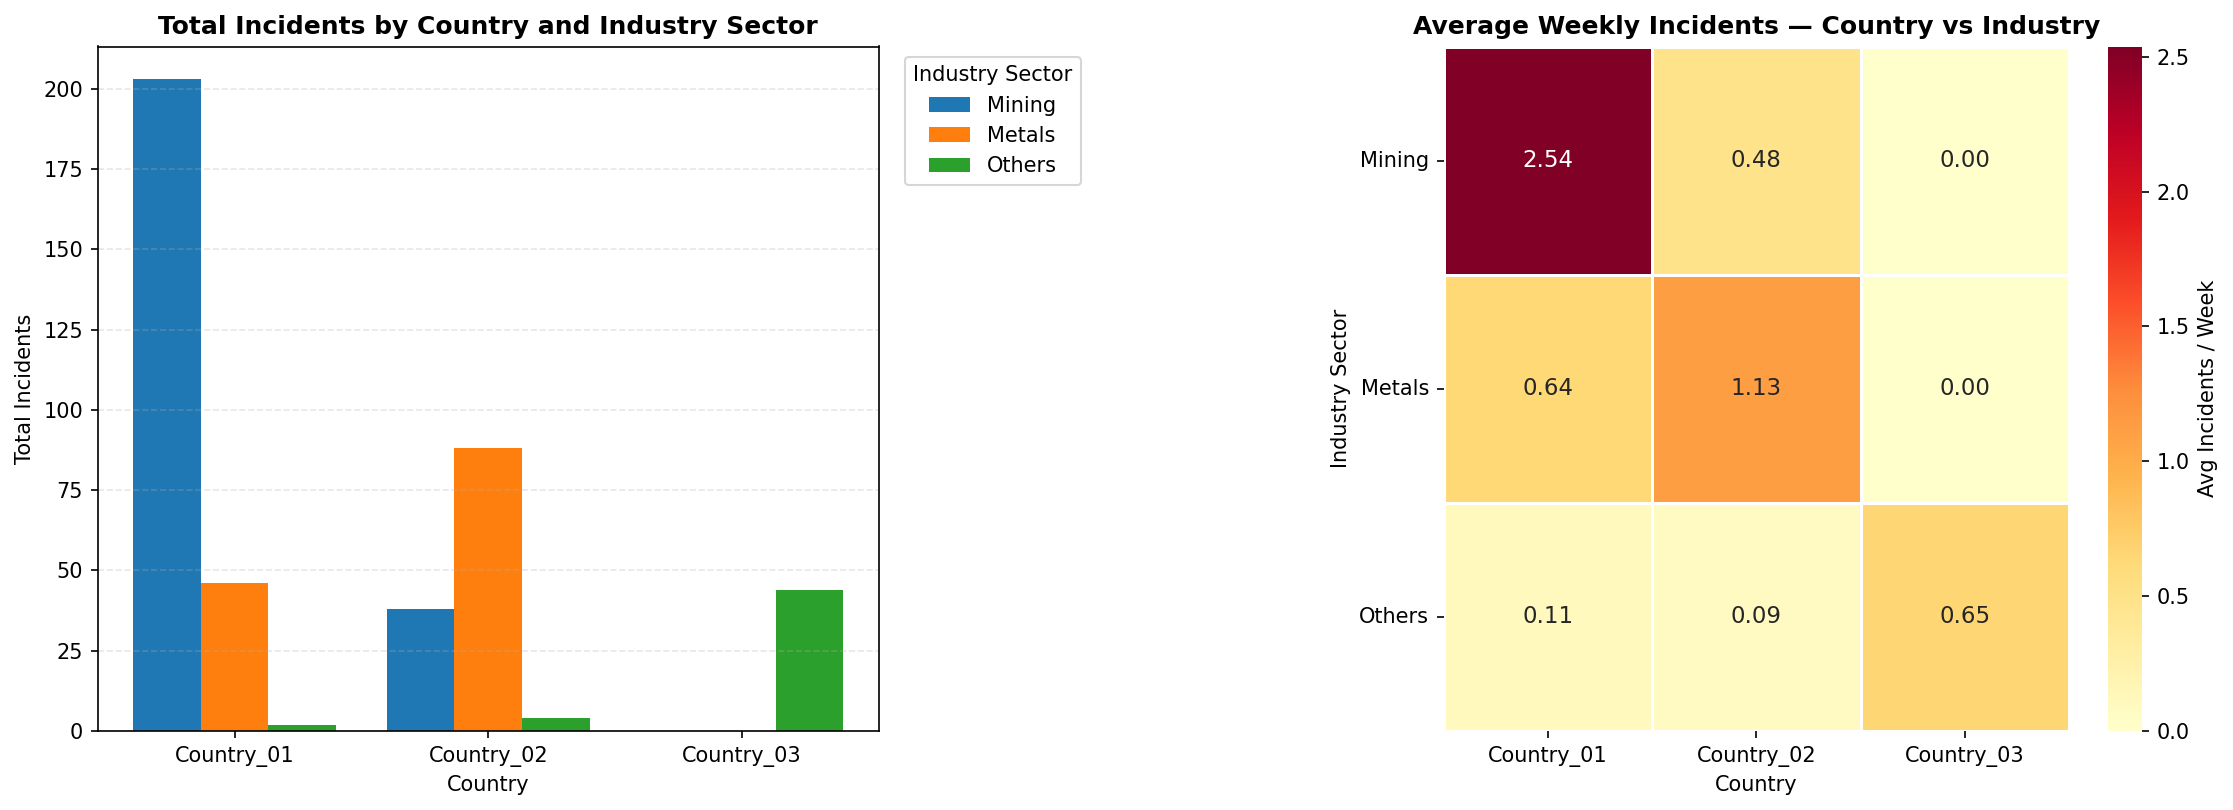

In [151]:
# === Weekly Incident Summary (Countries × Industry Sector) + Centered Visuals ===

# -------------------
# 0) Column names
# -------------------
DATE_COL = "Data"
COUNTRY_COL = "Countries"
IND_COL = "Industry Sector"

# -------------------
# 1) Ensure datetime
# -------------------
data_eda[DATE_COL] = pd.to_datetime(data_eda[DATE_COL], errors="coerce")

# -------------------
# 2) Weekly counts (long form)
# -------------------
weekly_long = (
    data_eda
      .set_index(DATE_COL)
      .groupby([COUNTRY_COL, IND_COL])
      .resample("W").size()
      .rename("count")
      .reset_index()
)

# -------------------
# 3) Stats per (Country, Industry)
# -------------------
grp = weekly_long.groupby([COUNTRY_COL, IND_COL])
stats = grp.agg(
    avg_per_week          = ("count", "mean"),
    peak_in_a_week        = ("count", "max"),
    weeks_with_incidents  = ("count", lambda s: (s > 0).sum()),
    active_weeks          = ("count", "size"),
    total_incidents       = ("count", "sum"),
).reset_index()

# Country share (% of total incidents within the country)
stats["country_share_%"] = (
    stats["total_incidents"] / stats.groupby(COUNTRY_COL)["total_incidents"].transform("sum") * 100
).fillna(0)

# -------------------
# 4) Tidy/rename/sort for display
# -------------------
stats_fmt = (
    stats.rename(columns={
        "avg_per_week": "Avg / Week",
        "peak_in_a_week": "Peak / Week",
        "weeks_with_incidents": "Weeks >0",
        "active_weeks": "Active Weeks",
        "total_incidents": "Total",
        "country_share_%": "Country Share"
    })
    [[COUNTRY_COL, IND_COL, "Avg / Week", "Peak / Week", "Weeks >0", "Active Weeks", "Total", "Country Share"]]
    .sort_values([COUNTRY_COL, "Total"], ascending=[True, False])
    .reset_index(drop=True)
)

for col in ["Avg / Week","Peak / Week","Weeks >0","Active Weeks","Total","Country Share"]:
    stats_fmt[col] = stats_fmt[col].astype(float)

# -------------------
# 5) Single heading (only above the summary table) + centered, styled table
# -------------------
display(HTML("""
<div style="text-align:center; margin:10px 0 6px;">
  <h2 style="font-weight:800; letter-spacing:.2px; margin:0;">
    Weekly Incidents by Industry Sector — Country wise
  </h2>
</div>
"""))

tbl = (
    stats_fmt.rename(columns={
        "Countries": "Country",
        "Industry Sector": "Industry",
        "Avg / Week": "Avg/Week",
        "Peak / Week": "Peak/Week",
        "Weeks >0": "Weeks>0",
        "Active Weeks": "Weeks(active)"
    })
)

styler = (
    tbl.style
      .format({
          "Avg/Week": "{:.2f}",
          "Peak/Week": "{:,.0f}",
          "Weeks>0": "{:,.0f}",
          "Weeks(active)": "{:,.0f}",
          "Total": "{:,.0f}",
          "Country Share": "{:.1f}%"
      })
      .hide(axis="index")
      .set_table_styles([
          {"selector": "thead th",
           "props": [("background-color", "#0f172a"),
                     ("color", "white"),
                     ("font-weight", "bold"),
                     ("text-align", "center"),
                     ("padding", "8px 10px")]},
          {"selector": "tbody td",
           "props": [("padding", "8px 10px")]}
      ])
      .set_properties(**{"text-align": "center"})
      .background_gradient(subset=["Country Share"], cmap="YlOrRd")
)

html_table = styler.to_html()
display(HTML(f"""
<div style="display:flex; justify-content:center;">
  <div style="max-width:1100px; overflow-x:auto;">
    {html_table}
  </div>
</div>
"""))

# =========================
# 6) Visualizations (side-by-side, centered output with gap) — NO heading here
# =========================

plt.close('all')  # close any old figures

countries  = stats_fmt[COUNTRY_COL].unique().tolist()
industries = stats_fmt[IND_COL].unique().tolist()

# Total incidents matrix
total_matrix = np.zeros((len(countries), len(industries)), dtype=float)
for i, c in enumerate(countries):
    row = stats_fmt[stats_fmt[COUNTRY_COL] == c]
    for j, ind in enumerate(industries):
        val = row.loc[row[IND_COL] == ind, "Total"]
        total_matrix[i, j] = float(val.iloc[0]) if not val.empty else 0.0

# Avg/Week matrix for heatmap
avg_matrix = np.zeros((len(industries), len(countries)), dtype=float)
for i, ind in enumerate(industries):
    col = stats_fmt[stats_fmt[IND_COL] == ind]
    for j, c in enumerate(countries):
        val = col.loc[col[COUNTRY_COL] == c, "Avg / Week"]
        avg_matrix[i, j] = float(val.iloc[0]) if not val.empty else 0.0

heatmap_df = pd.DataFrame(avg_matrix, index=industries, columns=countries)

# --- Figure (no suptitle)
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[1, 0.15, 1])

# Left: grouped bar
ax1 = fig.add_subplot(gs[0, 0])
x = np.arange(len(countries))
bar_width = 0.8 / max(len(industries), 1)
for idx, ind in enumerate(industries):
    offsets = (idx - (len(industries) - 1)/2) * bar_width
    ax1.bar(x + offsets, total_matrix[:, idx], width=bar_width, label=ind)

ax1.set_title("Total Incidents by Country and Industry Sector", fontsize=12, fontweight="bold")
ax1.set_xlabel("Country"); ax1.set_ylabel("Total Incidents")
ax1.set_xticks(x); ax1.set_xticklabels(countries, rotation=0)
ax1.legend(title="Industry Sector", loc="upper left", bbox_to_anchor=(1.02, 1))
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Spacer
ax_space = fig.add_subplot(gs[0, 1]); ax_space.axis("off")

# Right: heatmap
ax2 = fig.add_subplot(gs[0, 2])
sns.heatmap(
    heatmap_df, annot=True, fmt=".2f",
    cmap="YlOrRd", linewidths=0.5,
    cbar_kws={"label": "Avg Incidents / Week"},
    annot_kws={"size": 11}, ax=ax2
)
ax2.set_title("Average Weekly Incidents — Country vs Industry", fontsize=12, fontweight="bold")
ax2.set_xlabel("Country"); ax2.set_ylabel("Industry Sector")
ax2.tick_params(axis="x", rotation=0, labelsize=10)
ax2.tick_params(axis="y", rotation=0, labelsize=10)

plt.tight_layout(rect=[0.03, 0.02, 0.97, 0.94])

# Save + display centered (no plt.show, no duplicate)
buf = io.BytesIO()
fig.savefig(buf, format="png", bbox_inches="tight", dpi=150)
plt.close(fig)  # prevent duplicate auto-render

buf.seek(0)
b64 = base64.b64encode(buf.read()).decode("utf-8")
buf.close()

display(HTML(f"""
<div style="display:flex; justify-content:center; margin:20px 0;">
  <img src="data:image/png;base64,{b64}" style="width:1200px; max-width:95%; height:auto;"/>
</div>
"""))


**Observation:**

* Country_01 → Mining dominates (81%, avg. 2.54/week).

* Country_02 → Metals dominates (68%, avg. 1.13/week).

* Country_03 → Incidents entirely in Others (100%) which could indicate reporting gap.

####**Genre  wise  Accident Level and Potential Accident level**


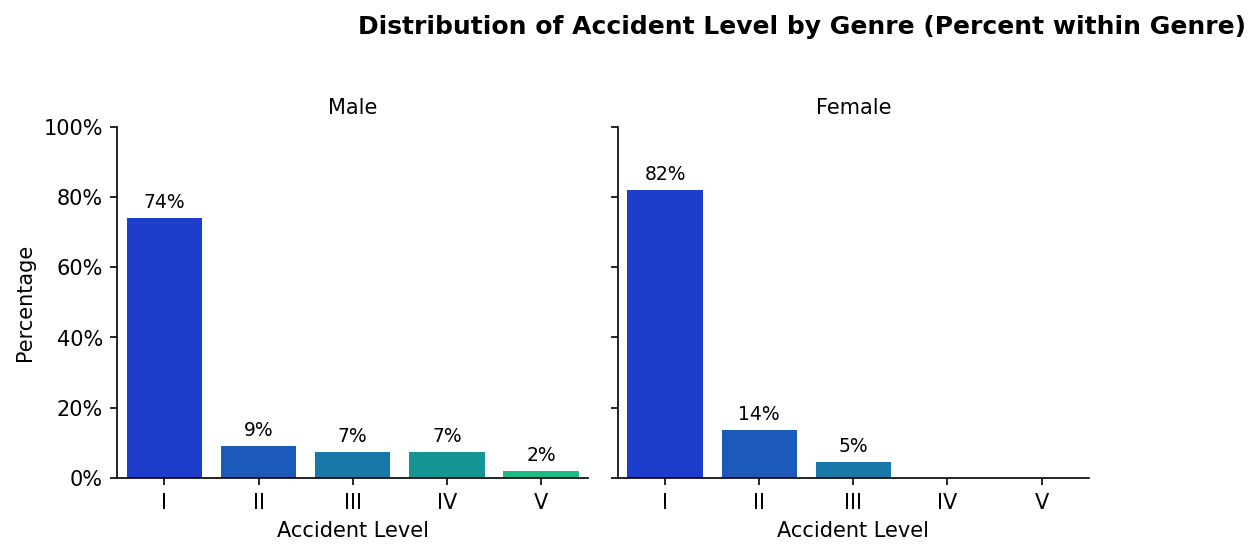
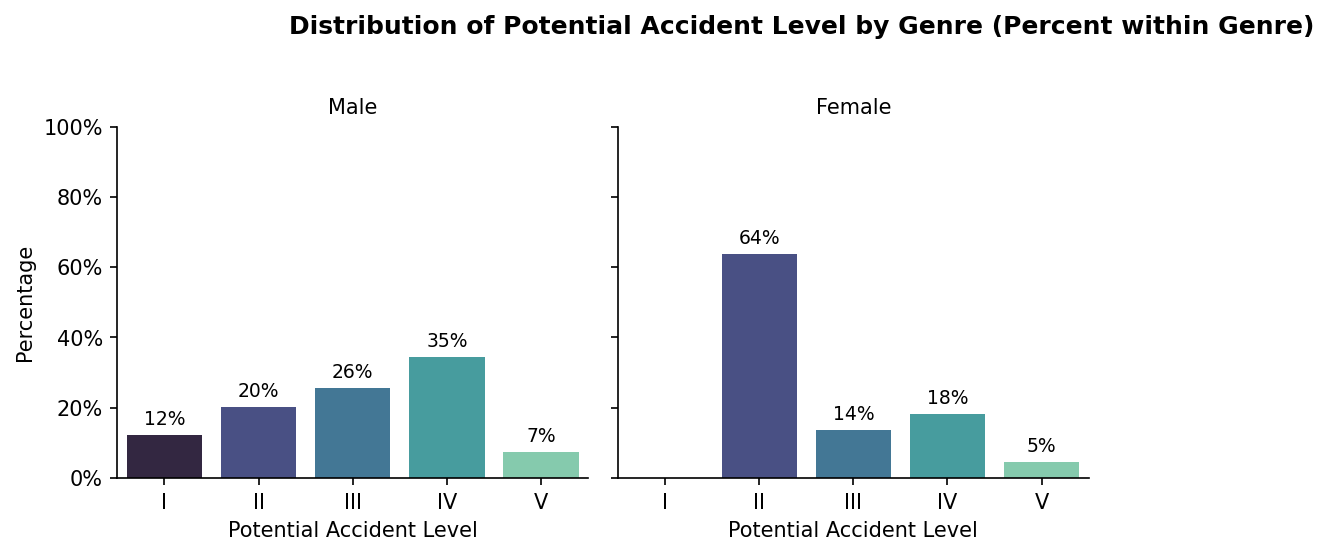

In [119]:
# === Side-by-Side Facets: Accident Level vs Potential Accident Level
#     (percentage within each Genre) ===

# ---------- Config ----------
level_order   = ['I', 'II', 'III', 'IV', 'V']   # x-axis order for levels
facet_col_wrap = 3                               # panels per row
facet_height   = 3.6                             # panel height (inches)

# ---------- Prepare data ----------
df = data.copy()  # assumes `data` DataFrame exists with columns: Genre, Accident Level, Potential Accident Level
df['Accident Level']           = pd.Categorical(df['Accident Level'],           categories=level_order, ordered=True)
df['Potential Accident Level'] = pd.Categorical(df['Potential Accident Level'], categories=level_order, ordered=True)

# Build complete grids so missing levels show as 0%
Genre = df['Genre'].dropna().unique()
idx_acc = pd.MultiIndex.from_product([Genre, level_order], names=['Genre', 'Accident Level'])
idx_pot = pd.MultiIndex.from_product([Genre, level_order], names=['Genre', 'Potential Accident Level'])

# ---------- Build percentage tables ----------
# Accident Level
counts_acc = (
    df.groupby(['Genre', 'Accident Level'], observed=False)
      .size()
      .reindex(idx_acc, fill_value=0)
      .reset_index(name='n')
)
counts_acc['pct'] = counts_acc['n'] / counts_acc.groupby('Genre')['n'].transform('sum').replace(0, 1)

# Potential Accident Level
counts_pot = (
    df.groupby(['Genre', 'Potential Accident Level'], observed=False)
      .size()
      .reindex(idx_pot, fill_value=0)
      .reset_index(name='n')
)
counts_pot['pct'] = counts_pot['n'] / counts_pot.groupby('Genre')['n'].transform('sum').replace(0, 1)

# ---------- Helper to draw a FacetGrid with % bars and labels ----------
def draw_facet_percentage(df_in, facet_col, x_col, x_label, title, palette):
    g = sns.FacetGrid(
        df_in, col=facet_col, col_wrap=facet_col_wrap,
        height=facet_height, sharey=True, legend_out=True
    )
    g.map_dataframe(
        sns.barplot,
        x=x_col, y='pct',
        order=level_order,
        hue=x_col, hue_order=level_order,
        palette=palette, dodge=False, errorbar=None  # seaborn ≥0.13
    )
    g.set_titles("{col_name}")
    g.set_axis_labels(x_label, "Percentage")
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax.set_ylim(0, 1)
        # % labels on bars
        for p in ax.patches:
            h = p.get_height()
            if h > 0:
                ax.annotate(f"{h*100:.0f}%", (p.get_x() + p.get_width()/2, h),
                            ha="center", va="bottom", fontsize=9, xytext=(0, 3),
                            textcoords="offset points")
    # one shared legend
    handles, labels = g.axes.flat[0].get_legend_handles_labels()
    if handles:
        g.fig.legend(handles, labels, title=x_label,
                     loc="center left", bbox_to_anchor=(1.02, 0.5))
    g.fig.suptitle(title, y=1.02, fontsize=12, fontweight="bold")
    g.tight_layout()
    return g.fig

# ---------- Draw the two figures (Accident vs Potential) ----------
plt.close('all')

fig_acc = draw_facet_percentage(
    counts_acc, facet_col='Genre',
    x_col='Accident Level', x_label='Accident Level',
    title='Distribution of Accident Level by Genre (Percent within Genre)',
    palette='winter'
)

fig_pot = draw_facet_percentage(
    counts_pot, facet_col='Genre',
    x_col='Potential Accident Level', x_label='Potential Accident Level',
    title='Distribution of Potential Accident Level by Genre (Percent within Genre)',
    palette='mako'
)

# ---------- Save both figures to base64 and show side-by-side, centered ----------
def fig_to_base64(fig, dpi=150):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", dpi=dpi)
    plt.close(fig)  # prevent duplicate auto-render
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode("utf-8")
    buf.close()
    return b64

b64_acc = fig_to_base64(fig_acc, dpi=150)
b64_pot = fig_to_base64(fig_pot, dpi=150)

display(HTML(f"""
<div style="display:flex; justify-content:center; gap:16px; margin:16px 0; align-items:flex-start; flex-wrap:wrap;">
  <img src="data:image/png;base64,{b64_acc}" style="width:48%; min-width:500px; height:auto;" />
  <img src="data:image/png;base64,{b64_pot}" style="width:48%; min-width:500px; height:auto;" />
</div>
"""))

**Observation:**

**Accident Level (actual incidents):**

* Both groups are mostly minor (Level I).

* **Females** have more minor incidents (~80% Level I).

* **Males** show a bit more Level II–IV and a small Level V tail.

**Potential Accident Level:**

* **Males**: Near-misses are more likely to be higher severity — many sit at Level III–IV.

* **Females**: Most near-misses are Level II (moderate); few reach Level III–IV, and Level V is rare.

* Very severe (Level V) is low for both.

####**Employee Type  vs  Accident Level and Potential Accident level**


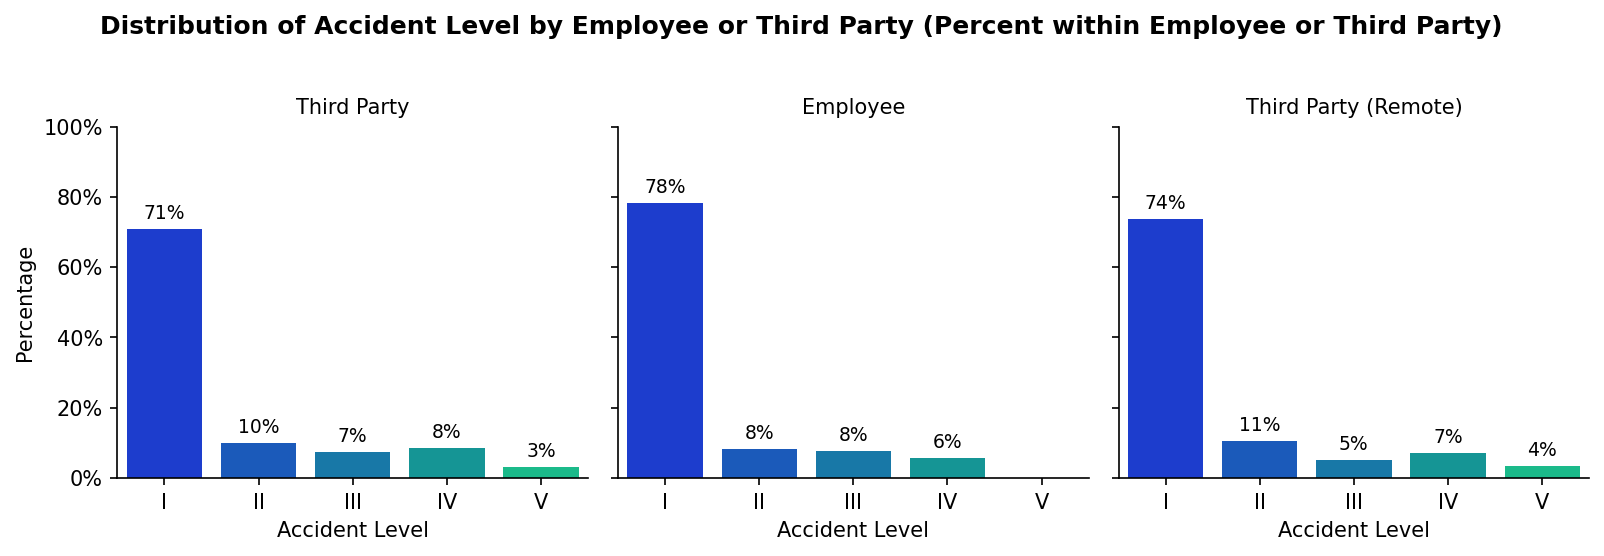
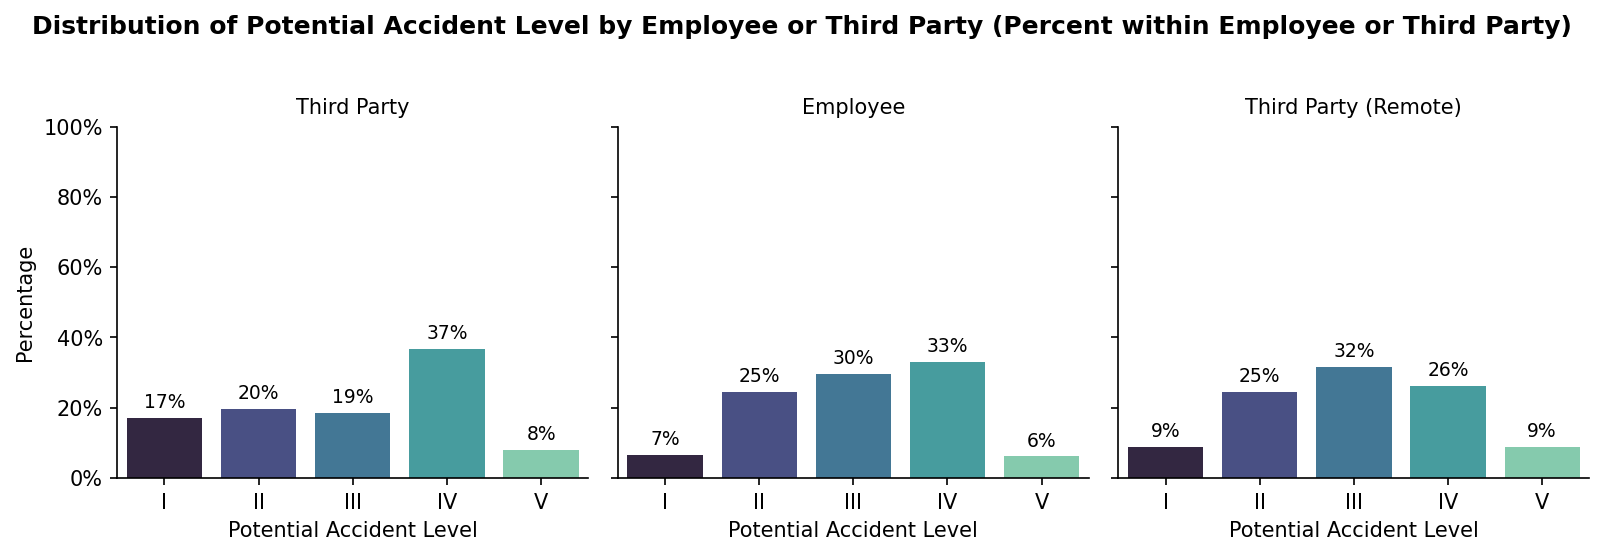

In [152]:
# === Side-by-Side Facets: Accident Level vs Potential Accident Level
#     (percentage within each Employee or Third Party) ===
# ---------- Config ----------
level_order   = ['I', 'II', 'III', 'IV', 'V']   # x-axis order for levels
facet_col_wrap = 3                               # panels per row
facet_height   = 3.6                             # panel height (inches)

# ---------- Prepare data ----------
df = data.copy()  # assumes `data` DataFrame exists with columns: Employee or Third Party, Accident Level, Potential Accident Level
df['Accident Level']           = pd.Categorical(df['Accident Level'],           categories=level_order, ordered=True)
df['Potential Accident Level'] = pd.Categorical(df['Potential Accident Level'], categories=level_order, ordered=True)

# Build complete grids so missing levels show as 0%
employee_type = df['Employee or Third Party'].dropna().unique()
idx_acc = pd.MultiIndex.from_product([employee_type, level_order], names=['Employee or Third Party', 'Accident Level'])
idx_pot = pd.MultiIndex.from_product([employee_type, level_order], names=['Employee or Third Party', 'Potential Accident Level'])

# ---------- Build percentage tables ----------
# Accident Level
counts_acc = (
    df.groupby(['Employee or Third Party', 'Accident Level'], observed=False)
      .size()
      .reindex(idx_acc, fill_value=0)
      .reset_index(name='n')
)
counts_acc['pct'] = counts_acc['n'] / counts_acc.groupby('Employee or Third Party')['n'].transform('sum').replace(0, 1)

# Potential Accident Level
counts_pot = (
    df.groupby(['Employee or Third Party', 'Potential Accident Level'], observed=False)
      .size()
      .reindex(idx_pot, fill_value=0)
      .reset_index(name='n')
)
counts_pot['pct'] = counts_pot['n'] / counts_pot.groupby('Employee or Third Party')['n'].transform('sum').replace(0, 1)

# ---------- Helper to draw a FacetGrid with % bars and labels ----------
def draw_facet_percentage(df_in, facet_col, x_col, x_label, title, palette):
    g = sns.FacetGrid(
        df_in, col=facet_col, col_wrap=facet_col_wrap,
        height=facet_height, sharey=True, legend_out=True
    )
    g.map_dataframe(
        sns.barplot,
        x=x_col, y='pct',
        order=level_order,
        hue=x_col, hue_order=level_order,
        palette=palette, dodge=False, errorbar=None  # seaborn ≥0.13
    )
    g.set_titles("{col_name}")
    g.set_axis_labels(x_label, "Percentage")
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax.set_ylim(0, 1)
        # % labels on bars
        for p in ax.patches:
            h = p.get_height()
            if h > 0:
                ax.annotate(f"{h*100:.0f}%", (p.get_x() + p.get_width()/2, h),
                            ha="center", va="bottom", fontsize=9, xytext=(0, 3),
                            textcoords="offset points")
    # one shared legend
    handles, labels = g.axes.flat[0].get_legend_handles_labels()
    if handles:
        g.fig.legend(handles, labels, title=x_label,
                     loc="center left", bbox_to_anchor=(1.02, 0.5))
    g.fig.suptitle(title, y=1.02, fontsize=12, fontweight="bold")
    g.tight_layout()
    return g.fig

# ---------- Draw the two figures (Accident vs Potential) ----------
plt.close('all')

fig_acc = draw_facet_percentage(
    counts_acc, facet_col='Employee or Third Party',
    x_col='Accident Level', x_label='Accident Level',
    title='Distribution of Accident Level by Employee or Third Party (Percent within Employee or Third Party)',
    palette='winter'
)

fig_pot = draw_facet_percentage(
    counts_pot, facet_col='Employee or Third Party',
    x_col='Potential Accident Level', x_label='Potential Accident Level',
    title='Distribution of Potential Accident Level by Employee or Third Party (Percent within Employee or Third Party)',
    palette='mako'
)

# ---------- Save both figures to base64 and show side-by-side, centered ----------
def fig_to_base64(fig, dpi=150):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", dpi=dpi)
    plt.close(fig)  # prevent duplicate auto-render
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode("utf-8")
    buf.close()
    return b64

b64_acc = fig_to_base64(fig_acc, dpi=150)
b64_pot = fig_to_base64(fig_pot, dpi=150)

display(HTML(f"""
<div style="display:flex; justify-content:center; gap:16px; margin:16px 0; align-items:flex-start; flex-wrap:wrap;">
  <img src="data:image/png;base64,{b64_acc}" style="width:48%; min-width:500px; height:auto;" />
  <img src="data:image/png;base64,{b64_pot}" style="width:48%; min-width:500px; height:auto;" />
</div>
"""))

**Observation**

**Accident Level (actual incidents):**

* Most events are minor (Level I) for all groups (Employee, Third-Party, Third-Party Remote).

* Employees have the safest profile (highest Level-I, very little Level-V).

* Third-Party Remote shows more Level-II and the highest Level-V (worst-case) → needs attention.

* On-site Third-Party also has a small Level-V tail.

**Potential Accident Level (what could happen):**

* All groups can escalate, but Third-Party work leans higher: a lot of Level-IV, and Remote Third-Party has the most Level-V potential.

####**Genre Vs Industry Sector and Genre  Employee Type**

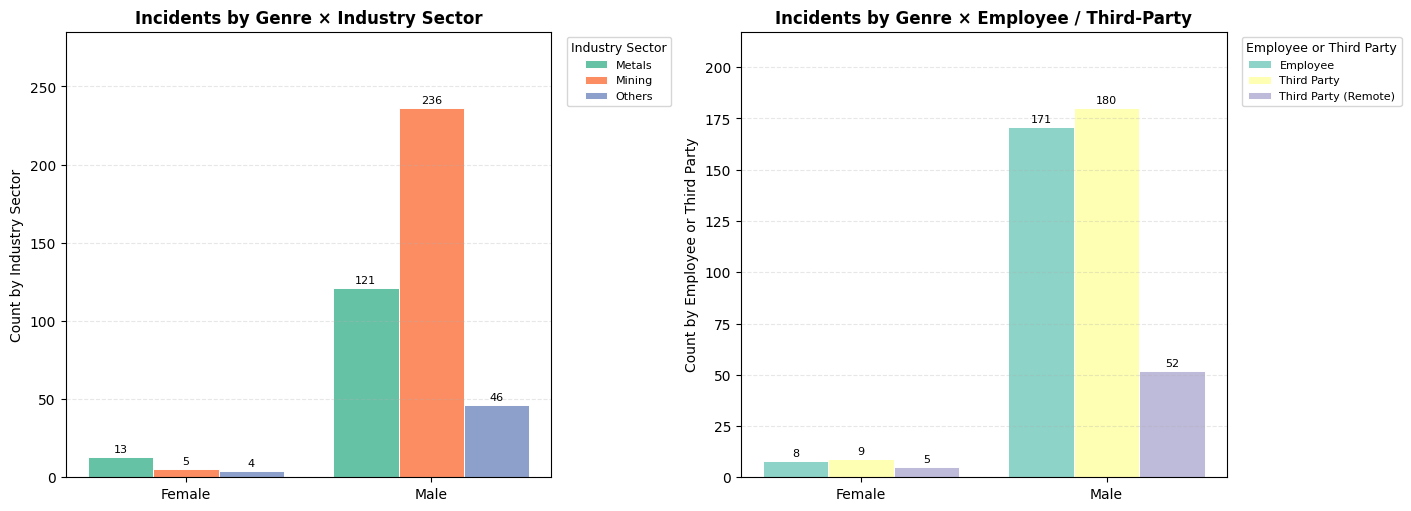

In [153]:

GENRE_COL = "Genre"
IND_COL   = "Industry Sector"
ETP_COL   = "Employee or Third Party"   # e.g. values: Employee, Third Party, Third Party (Remote)

# ==== Data ====
df = data_eda.copy()

# ---- counts (use normalize=True per-genre if you want percentages) ----
normalize = False  # set True to plot % share within each Genre

def make_pivot(frame, col_b):
    tbl = (frame.groupby([GENRE_COL, col_b], observed=False)
                 .size()
                 .rename("Count")
                 .reset_index())
    piv = tbl.pivot(index=GENRE_COL, columns=col_b, values="Count").fillna(0)
    if normalize:
        piv = piv.div(piv.sum(axis=1).replace(0, 1), axis=0) * 100
    return piv

piv_ind = make_pivot(df, IND_COL).astype(float)
piv_etp = make_pivot(df, ETP_COL).astype(float)

# Keep consistent order
genres = list(piv_ind.index)
palette1 = sns.color_palette("Set2", n_colors=len(piv_ind.columns))
palette2 = sns.color_palette("Set3", n_colors=len(piv_etp.columns))

def plot_grouped(ax, pivot, title, ylabel):
    x = np.arange(len(pivot.index))              # genres
    cols = list(pivot.columns)
    bar_w = 0.8 / max(1, len(cols))              # keep bars within slot

    for j, col in enumerate(cols):
        offs = (j - (len(cols)-1)/2) * bar_w
        vals = pivot[col].values
        ax.bar(x + offs, vals, width=bar_w,
               label=str(col),
               color=(palette1 if ylabel.endswith(IND_COL) else palette2)[j],
               edgecolor="white", linewidth=0.7)

        # annotate values (hide zeros)
        for xi, v in enumerate(vals):
            if v > 0:
                txt = f"{v:.0f}%" if normalize else f"{int(v):,}"
                ax.annotate(txt, (x[xi] + offs, v),
                            ha="center", va="bottom", fontsize=8, xytext=(0, 2),
                            textcoords="offset points")

    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xticks(x); ax.set_xticklabels(pivot.index, rotation=0)
    ax.set_ylabel(ylabel)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.legend(title=ylabel.split(" by ")[-1], fontsize=8, title_fontsize=9,
              loc="upper left", bbox_to_anchor=(1.02, 1))

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

yl = "Percentage" if normalize else "Count"
plot_grouped(
    axes[0], piv_ind,
    title="Incidents by Genre × Industry Sector",
    ylabel=f"{yl} by {IND_COL}"
)
plot_grouped(
    axes[1], piv_etp,
    title="Incidents by Genre × Employee / Third-Party",
    ylabel=f"{yl} by {ETP_COL}"
)

for ax in axes:
    # nice y-range
    ymax = max(5, ax.get_ylim()[1])
    ax.set_ylim(0, ymax * 1.15)

plt.show()



**Observation:**

* Incidents are heavily male-dominated; female counts are small across all views.

* By sector, Mining drives most incidents (especially for males), followed by Metals; Others is much lower.

* By engagement type, Third-Party (incl. remote) is slightly higher than Employees for males; Remote Third-Party is smaller but not trivial.

####**Critical Risk Vs Accident Level**

In [113]:
acc_cr = data_eda.pivot_table(index='Critical Risk',
                          columns='Accident Level',
                          aggfunc='size')

acc_cr = acc_cr.fillna(0).astype(int)        # convert to int if counts
acc_cr['total'] = acc_cr.sum(axis=1)

acc_cr.style.background_gradient(cmap='Blues')

Accident Level,I,II,III,IV,V,total
Critical Risk,,,,,,
Not applicable,0,0,0,1,0,1
Bees,10,0,0,0,0,10
Blocking and isolation of energies,3,0,0,0,0,3
Burn,0,0,1,0,0,1
Chemical substances,15,2,0,0,0,17
Confined space,1,0,0,0,0,1
Cut,11,2,1,0,0,14
Electrical Shock,2,0,0,0,0,2
Electrical installation,0,0,0,1,0,1


**Observation:**

* “Others” dominates with 232 incidents—far above the next categories (Pressed 24, Manual Tools 20, Chemical substances 17). This signals a taxonomy/reporting gap.

* Severity mix: Level I incidents are the majority across categories; Level IV–V are rare overall.

**Where severe cases appear:**

* Others: highest absolute severe count (IV=13, V=3) due to volume.

* Power lock: 2 of 3 are Level V → very high severity rate.

* Pressed: notable Level IV = 4.

* Fall: has Level IV/V entries—needs attention.

####**Critical Risk Vs Potential Accident  Level**

In [124]:
acc_cr = data.pivot_table(index='Critical Risk',
                          columns='Potential Accident Level',
                          aggfunc='size')

acc_cr = acc_cr.fillna(0).astype(int)        # convert to int if counts
acc_cr['total'] = acc_cr.sum(axis=1)

acc_cr.style.background_gradient(cmap='Blues')

/tmp/ipython-input-2444740806.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  acc_cr = data.pivot_table(index='Critical Risk',


Potential Accident Level,I,II,III,IV,V,total
Critical Risk,,,,,,
Not applicable,0,0,0,0,1,1
Bees,10,0,0,0,0,10
Blocking and isolation of energies,0,1,2,0,0,3
Burn,0,0,0,1,0,1
Chemical substances,0,5,8,4,0,17
Confined space,0,0,1,0,0,1
Cut,1,6,5,2,0,14
Electrical Shock,0,0,0,2,0,2
Electrical installation,0,0,0,0,1,1


**Observation:**

* Biggest bucket: Others (232) — too broad; reclassify to act on it.

* Highest specific totals: Pressed (24), Manual Tools (20), Chemical substances (17).

* Severe-heavy risks (IV–V): Vehicles/Mobile Equipment (IV=2, V=4), Power lock (V=3), Projection (IV=7, V=2), Pressed (IV=7, V=1), Suspended Loads (IV=5), Fall prevention (IV=5).

* Mostly low severity: Bees (all I=10), Venomous Animals (mainly I=13), Manual Tools (peaks at II–III), Cut (II–III).

* Notable singles: Level VI appears once (Remains of choco).

####**Critical Risk Vs Industry Sector**

In [115]:
industry_cr = data_eda.pivot_table(index='Critical Risk',
                          columns='Industry Sector',
                          aggfunc='size')

industry_cr = industry_cr.fillna(0).astype(int)        # convert to int if counts
industry_cr['total'] = industry_cr.sum(axis=1)

industry_cr.style.background_gradient(cmap='Blues')

Industry Sector,Metals,Mining,Others,total
Critical Risk,,,,
Not applicable,1,0,0,1
Bees,0,0,10,10
Blocking and isolation of energies,3,0,0,3
Burn,1,0,0,1
Chemical substances,15,2,0,17
Confined space,1,0,0,1
Cut,10,4,0,14
Electrical Shock,0,2,0,2
Electrical installation,0,1,0,1


**Observation:**

* Mining has the most incidents, mainly due to a very large “Others” count (179).

* Metals is second; top risks here are Pressed (17), Chemical substances (15), and Manual tools (14).

* Others sector is small but skewed to animal/insect hazards: Venomous animals (13) and Bees (10).

###**Accident Level vs Top words as part of incident Description**

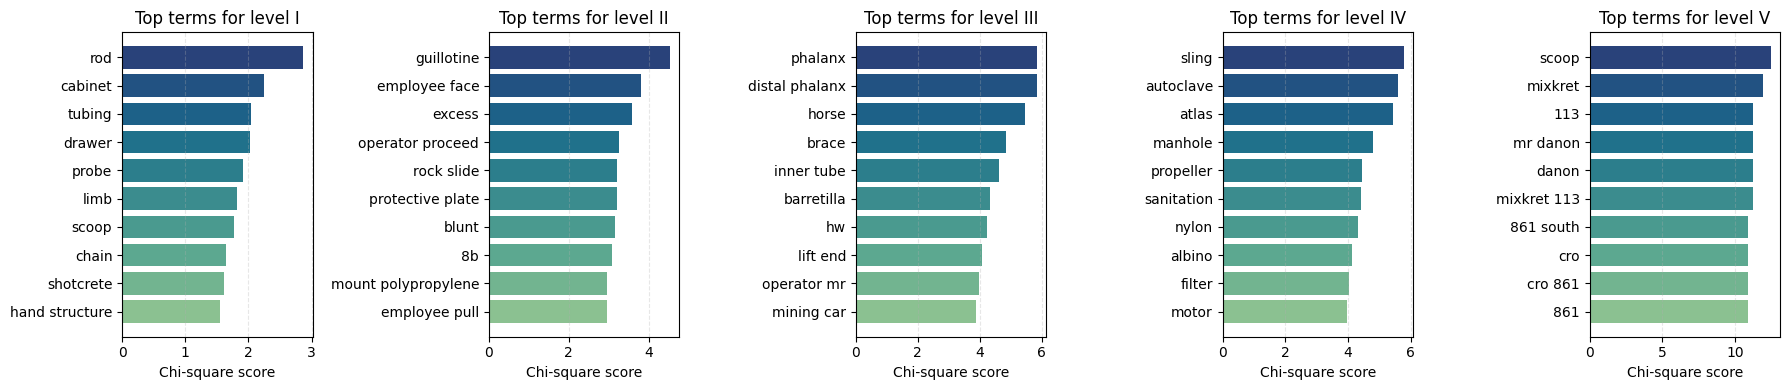

In [174]:

level_order = ['I','II','III','IV','V']
data_eda['Accident Level'] = pd.Categorical(data_eda['Accident Level'], categories=level_order, ordered=True)

vec = TfidfVectorizer(stop_words='english', max_features=8000, ngram_range=(1,2))
X = vec.fit_transform(df['final_cleaned_text'])
feat_names = np.array(vec.get_feature_names_out())

n_top = 10
fig, axes = plt.subplots(1, len(level_order), figsize=(18,4), sharey=False)

for i, lvl in enumerate(level_order):
    y = (data_eda['Accident Level'] == lvl).astype(int).values
    chi, _ = chi2(X, y)
    idx = np.argsort(chi)[-n_top:]
    top_feats = feat_names[idx]
    top_scores = chi[idx]
    order = np.argsort(top_scores)  # ascending for nicer horizontal bars

    ax = axes[i]
    ax.barh(top_feats[order], top_scores[order], color=sns.color_palette('crest', n_top))
    ax.set_title(f'Top terms for level {lvl}')
    ax.set_xlabel('Chi-square score'); ax.set_ylabel('')
    ax.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout(); plt.show()

**Observation:**


* **Level I (minor):**
rod — small metal bar; cabinet / drawer — storage units; tubing — hose/pipe; probe — small test tool.
➜ Mostly handling/housekeeping issues with small parts and storage.

* **Level II (low–moderate):**
guillotine — cutting/shearing machine; blunt — non-sharp impact; protective plate — machine guard; rock slide — falling rock; face — face exposure.
➜ Guarding and face/eye protection need attention; keep hands clear of cutting/impact points.

* **Level III (moderate)**:
phalanx / distal phalanx — finger bones; brace — support device; inner tube — rubber tube/component.
➜ Many hand/finger injuries → tighten pinch-point and line-of-fire controls.

* **Level IV (high):**
sling — lifting strap/rigging; autoclave — pressurized steam vessel; manhole — confined-space entry; propeller / motor — rotating machinery.
➜ High-energy work (lifting, pressure, confined space, rotating parts) → enforce permits, LOTO, rigging checks, and guards.

* **Level V (very high):**
scoop — Scooptram/LHD underground loader; Mixkret — shotcrete transport/spraying vehicle; 861 — equipment/area ID.
➜ Risks concentrate around mobile equipment and shotcrete operations → strengthen traffic management, spotter use, proximity controls, and route/speed discipline.

## **Model Training**

In [ ]:
# Pre Settings common for all models
RANDOM_STATE = 42

### **Split train & test**

In [ ]:
from sklearn.model_selection import train_test_split

# Define features & labels
X = data['final_cleaned_text'].values
y = data['Accident Level'].values

#Split train & test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)


### Define vectorizers (BoW and TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=2)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, sublinear_tf=True)

### Define evaluation function

In [ ]:
# Shared results list -> final DF for comparison
RESULTS = []

In [ ]:
from collections import Counter

#To Show Class imbalance
def show_class_balance(y_vec, title="Class balance"):
    cnt = Counter(y_vec)
    total = sum(cnt.values())
    df = pd.DataFrame({
        "Class": list(cnt.keys()),
        "Count": list(cnt.values()),
        "Percent": [round(100*v/total, 2) for v in cnt.values()]
    }).sort_values("Count", ascending=False).reset_index(drop=True)
    print(title)
    display(df)
    return df

In [ ]:
def evaluate_and_log(model, Xtr, ytr, Xte, yte, label, results_list, show_cm=True):
    # Train the model
    model.fit(Xtr, ytr)

    # Predictions
    ytr_pred = model.predict(Xtr)
    yte_pred = model.predict(Xte)

    # Metrics
    train_acc = accuracy_score(ytr, ytr_pred)
    test_acc  = accuracy_score(yte, yte_pred)
    test_f1   = f1_score(yte, yte_pred, average="macro", zero_division=0)

    # Print report
    print(f"\n{label} Results")
    print(f"Train Accuracy: {train_acc:.3f}")
    print(f"Test  Accuracy: {test_acc:.3f}")
    print(f"Test  Macro-F1: {test_f1:.3f}\n")
    print(classification_report(yte, yte_pred, digits=3, zero_division=0))

    # Confusion matrix
    if show_cm:
        classes = np.unique(yte)
        cm = confusion_matrix(yte, yte_pred, labels=classes)
        sns.heatmap(cm, annot=True, fmt='d',
                    xticklabels=classes, yticklabels=classes,
                    cmap="Blues")
        plt.title(f"{label} - Confusion Matrix")
        plt.ylabel("True")
        plt.xlabel("Predicted")
        plt.show()

    # Append to results list with consistent keys
    results_list.append({
        "Model": label,
        "Train Accuracy": round(train_acc, 3),
        "Test Accuracy": round(test_acc, 3),
        "Test Macro-F1": round(test_f1, 3)
    })


### Check class imbalance

In [ ]:
_ = show_class_balance(y, title="Overall class balance")

- The class imbalance is very high across classes

In [ ]:
_ = show_class_balance(y_train, title="Train split balance")

In [ ]:
_ = show_class_balance(y_test,  title="Test split balance")

- Our dataset was heavily imbalanced, with ~74% of accidents labeled as Level I while severe cases (Levels III, IV and V) had fewer than 10 examples.
- Without balancing, models tended to predict only the majority class, leading to high accuracy but poor macro-F1.
- Apply Random Oversampling on the training data to give minority classes equal representation, ensuring the model could also learn patterns from rare but critical severe accidents

### Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(random_state=RANDOM_STATE)

### Train AdaBoost with BoW

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline


# Base (weak) learner with class_weight to help skew
weak_learner = DecisionTreeClassifier(max_depth=1, class_weight="balanced", random_state=RANDOM_STATE)

ada_params = dict(estimator=weak_learner, n_estimators=200, learning_rate=0.5, random_state=RANDOM_STATE)

# Pipelines
ada_bow_plain = ImbPipeline([
    ("bow", bow_vectorizer),
    ("clf", AdaBoostClassifier(**ada_params))
])

ada_tfidf_plain = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", AdaBoostClassifier(**ada_params))
])

ada_bow_overs = ImbPipeline([
    ("bow", bow_vectorizer),
    ("oversample", sampler),
    ("clf", AdaBoostClassifier(**ada_params))
])

ada_tfidf_overs = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("oversample", sampler),
    ("clf", AdaBoostClassifier(**ada_params))
])

In [ ]:
# Evaluate AdaBoost BoW without over sampling
evaluate_and_log(ada_bow_plain,  X_train, y_train, X_test, y_test, "AdaBoost (BoW)", RESULTS)

In [ ]:
# Evaluate AdaBoost TFIDF without over sampling
evaluate_and_log(ada_tfidf_plain,X_train, y_train, X_test, y_test, "AdaBoost (TF-IDF)", RESULTS)

In [ ]:
# Evaluate AdaBoost BoW with over sampling
evaluate_and_log(ada_bow_overs,  X_train, y_train, X_test, y_test, "AdaBoost (BoW + Oversample)", RESULTS)

In [ ]:
# Evaluate AdaBoost TFIDF with over sampling
evaluate_and_log(ada_tfidf_overs,X_train, y_train, X_test, y_test, "AdaBoost (TF-IDF + Oversample)", RESULTS)

In [ ]:
# Compare Results
pd.DataFrame(RESULTS).sort_values("Test Accuracy", ascending=False)

### Hyper-parameter tuning

In [ ]:
#utility method to build base pipeline
def build_ada_pipeline(vectorizer):
    return ImbPipeline([
        (vectorizer.__class__.__name__.lower(), vectorizer),
        ("oversample", sampler),  # keep in-CV balancing
        ("clf", AdaBoostClassifier(
            estimator=DecisionTreeClassifier(class_weight="balanced", random_state=RANDOM_STATE),
            random_state=RANDOM_STATE
        ))
    ])

In [ ]:
# Hyper Parameters to be tuned
ada_grid = {
    "clf__n_estimators":  [100, 200, 400],
    "clf__learning_rate": [0.1, 0.3, 0.5, 1.0],
    "clf__estimator__max_depth": [1, 2],
    "clf__estimator__min_samples_leaf": [1, 2]
}

#### Hyper parameter tuning for Bow

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define a stratified 5-fold cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
from sklearn.model_selection import GridSearchCV


# Build the AdaBoost pipeline using Bag-of-Words features
pipe_bow   = build_ada_pipeline(bow_vectorizer)

# Set up GridSearchCV for hyperparameter tuning
grid_bow = GridSearchCV(
    estimator=pipe_bow,
    param_grid=ada_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score="raise"  # fail fast if something is wrong
)

# Run the grid search on the training data
grid_bow.fit(X_train, y_train)

print("Best BoW params:", grid_bow.best_params_, "CV Macro-F1:", round(grid_bow.best_score_, 3))


#### Hyper parameter tuning for TF-IDF

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Build the AdaBoost pipeline using TDIDF features
pipe_tfidf = build_ada_pipeline(tfidf_vectorizer)

# Set up GridSearchCV for hyperparameter tuning
grid_tfidf = GridSearchCV(
    estimator=pipe_tfidf,
    param_grid=ada_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score="raise"
)

# Run the grid search on the training data
grid_tfidf.fit(X_train, y_train)

print("Best TF-IDF params:", grid_tfidf.best_params_, "CV Macro-F1:", round(grid_tfidf.best_score_, 3))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best TF-IDF params: {'clf__estimator__max_depth': 2, 'clf__estimator__min_samples_leaf': 2, 'clf__learning_rate': 1.0, 'clf__n_estimators': 400} CV Macro-F1: 0.698



AdaBoost (BoW + TUNED) Results
Train Accuracy: 0.922
Test  Accuracy: 0.619
Test  Macro-F1: 0.236

              precision    recall  f1-score   support

           I      0.746     0.806     0.775        62
          II      0.111     0.125     0.118         8
         III      0.000     0.000     0.000         6
          IV      1.000     0.167     0.286         6
           V      0.000     0.000     0.000         2

    accuracy                          0.619        84
   macro avg      0.371     0.220     0.236        84
weighted avg      0.633     0.619     0.604        84



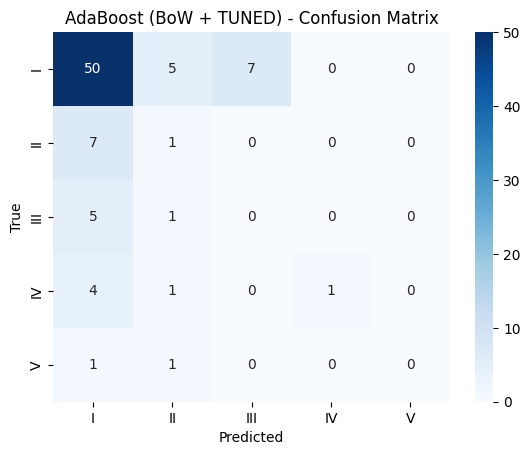

In [ ]:
#Evaluate AdaBoost with BoW + Tuned
_ = evaluate_and_log(grid_bow.best_estimator_,   X_train, y_train, X_test, y_test,
                     "AdaBoost (BoW + TUNED)", RESULTS)


AdaBoost (TF-IDF + TUNED) Results
Train Accuracy: 0.964
Test  Accuracy: 0.619
Test  Macro-F1: 0.158

              precision    recall  f1-score   support

           I      0.743     0.839     0.788        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.619        84
   macro avg      0.149     0.168     0.158        84
weighted avg      0.548     0.619     0.582        84



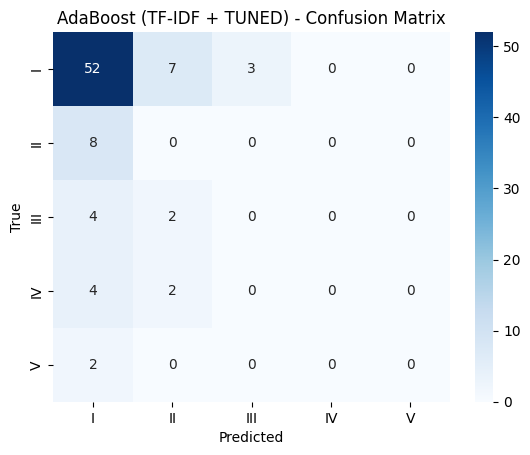

In [ ]:
#Evaluate AdaBoost with TF-IDF + Tuned
_ = evaluate_and_log(grid_tfidf.best_estimator_, X_train, y_train, X_test, y_test,
                     "AdaBoost (TF-IDF + TUNED)", RESULTS)

In [ ]:
#Compare results
final_df = pd.DataFrame(RESULTS).sort_values(["Test Accuracy"], ascending=False).reset_index(drop=True)
display(final_df)

,Model,Train Accuracy,Test Accuracy,Test Macro-F1
0,AdaBoost (BoW),0.746,0.738,0.170
1,AdaBoost (TF-IDF),0.746,0.738,0.170
2,AdaBoost (TF-IDF + TUNED),0.964,0.619,0.158
3,AdaBoost (BoW + TUNED),0.922,0.619,0.236
4,AdaBoost (TF-IDF + Oversample),0.719,0.571,0.254
5,AdaBoost (BoW + Oversample),0.581,0.452,0.253


- Based on Accuracy, AdaBoost (BoW / TF-IDF base) seems better (0.738) along with AdaBoost (BoW)

### SVM Model Starts

In [ ]:
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline

# Define SVM model
svm = SVC(kernel='poly', degree=3, random_state=RANDOM_STATE) # Added random_state for reproducibility

# Pipelines for SVM
svm_bow_plain = ImbPipeline([
    ("bow", bow_vectorizer),
    ("clf", svm)
])

svm_tfidf_plain = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", svm)
])

svm_bow_overs = ImbPipeline([
    ("bow", bow_vectorizer),
    ("oversample", sampler),
    ("clf", svm)
])

svm_tfidf_overs = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("oversample", sampler),
    ("clf", svm)
])


SVM (BoW) Results
Train Accuracy: 0.850
Test  Accuracy: 0.738
Test  Macro-F1: 0.170

              precision    recall  f1-score   support

           I      0.738     1.000     0.849        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.148     0.200     0.170        84
weighted avg      0.545     0.738     0.627        84



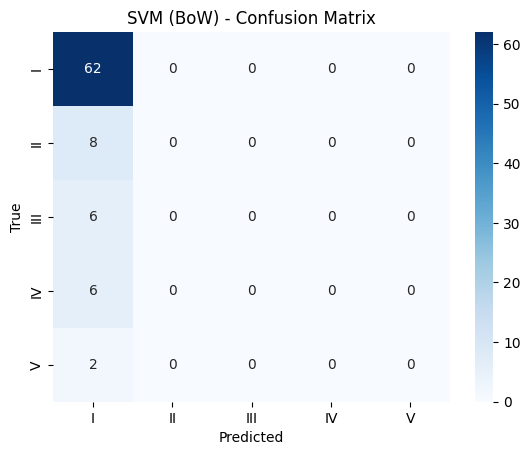

In [ ]:
# Evaluate AdaBoost BoW without over sampling
evaluate_and_log(svm_bow_plain,  X_train, y_train, X_test, y_test, "SVM (BoW)", RESULTS)


SVM (TF-IDF) Results
Train Accuracy: 0.991
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



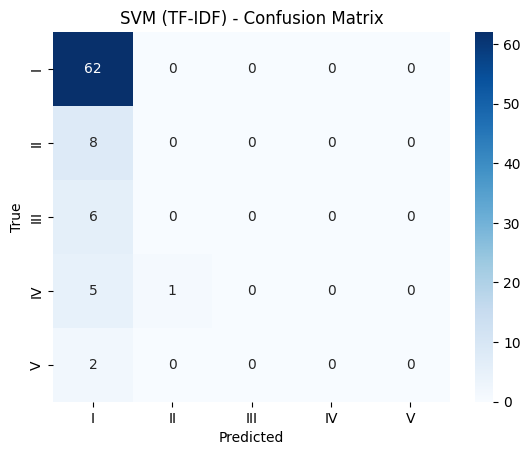

In [ ]:
# Evaluate AdaBoost TFIDF without over sampling
evaluate_and_log(svm_tfidf_plain,X_train, y_train, X_test, y_test, "SVM (TF-IDF)", RESULTS)


SVM (BoW + Oversample) Results
Train Accuracy: 0.958
Test  Accuracy: 0.738
Test  Macro-F1: 0.170

              precision    recall  f1-score   support

           I      0.738     1.000     0.849        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.148     0.200     0.170        84
weighted avg      0.545     0.738     0.627        84



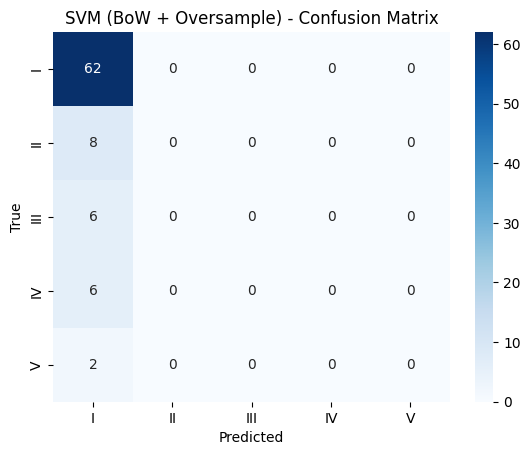

In [ ]:
# Evaluate AdaBoost BoW with over sampling
evaluate_and_log(svm_bow_overs,  X_train, y_train, X_test, y_test, "SVM (BoW + Oversample)", RESULTS)


SVM (TF-IDF + Oversample) Results
Train Accuracy: 0.991
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



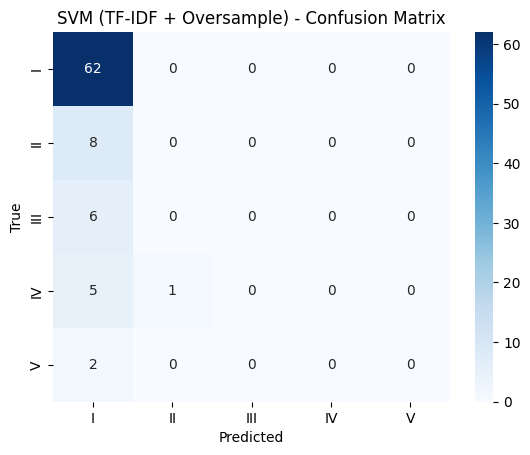

In [ ]:
# Evaluate AdaBoost TFIDF with over sampling
evaluate_and_log(svm_tfidf_overs,X_train, y_train, X_test, y_test, "SVM (TF-IDF + Oversample)", RESULTS)

In [ ]:
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline

# Define SVM model
svm_gamma = SVC(kernel='poly', degree=3, gamma=0.3,C=0.1, random_state=RANDOM_STATE) # Added random_state for reproducibility

# Pipelines for SVM
svm_bow_plain_gamma = ImbPipeline([
    ("bow", bow_vectorizer),
    ("clf", svm_gamma)
])

svm_tfidf_plain_gamma = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", svm_gamma)
])

svm_bow_overs_gamma = ImbPipeline([
    ("bow", bow_vectorizer),
    ("oversample", sampler),
    ("clf", svm_gamma)
])

svm_tfidf_overs_gamma = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("oversample", sampler),
    ("clf", svm_gamma)
])


SVM GAMMA (BoW) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



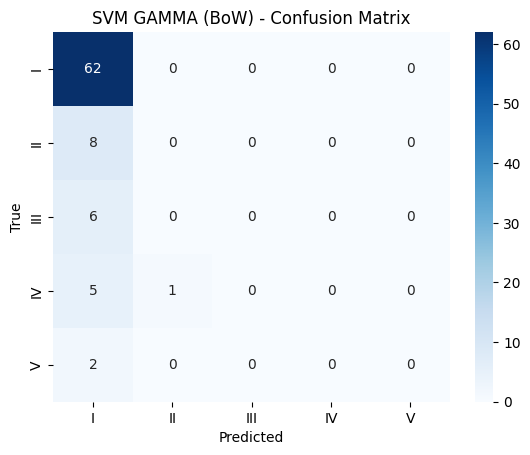

In [ ]:
# Evaluate AdaBoost BoW without over sampling
evaluate_and_log(svm_bow_plain_gamma,  X_train, y_train, X_test, y_test, "SVM GAMMA (BoW)", RESULTS)


SVM GAMMA (TF-IDF) Results
Train Accuracy: 0.740
Test  Accuracy: 0.738
Test  Macro-F1: 0.170

              precision    recall  f1-score   support

           I      0.738     1.000     0.849        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.148     0.200     0.170        84
weighted avg      0.545     0.738     0.627        84



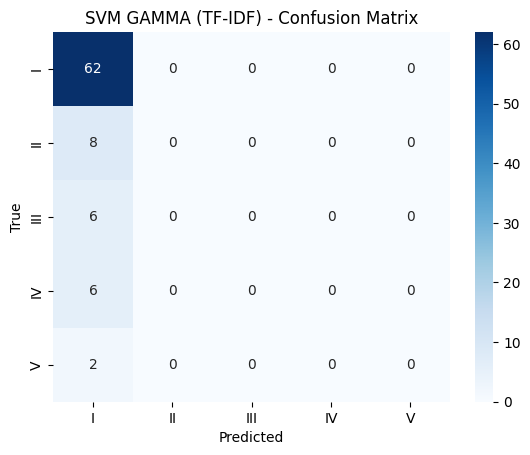

In [ ]:
# Evaluate AdaBoost TFIDF without over sampling
evaluate_and_log(svm_tfidf_plain_gamma,X_train, y_train, X_test, y_test, "SVM GAMMA (TF-IDF)", RESULTS)


SVM GAMMA (BoW + Oversample) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



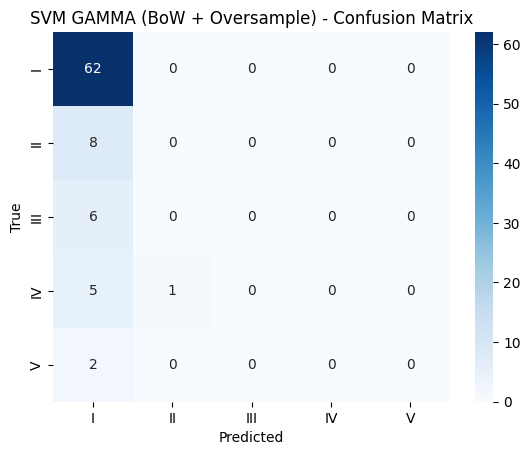

In [ ]:
# Evaluate AdaBoost BoW with over sampling
evaluate_and_log(svm_bow_overs_gamma,  X_train, y_train, X_test, y_test, "SVM GAMMA (BoW + Oversample)", RESULTS)


SVM (TF-IDF + Oversample) Results
Train Accuracy: 0.958
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



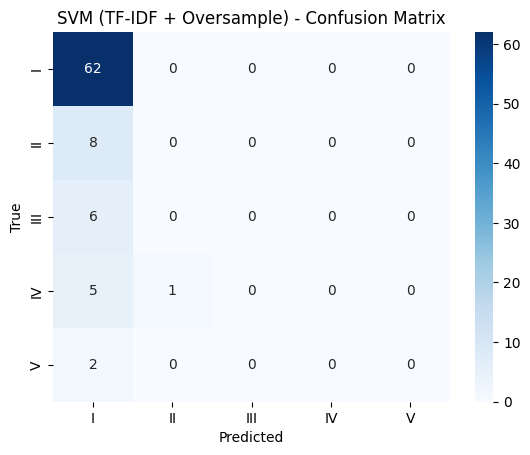

In [ ]:
# Evaluate AdaBoost TFIDF with over sampling
evaluate_and_log(svm_tfidf_overs_gamma,X_train, y_train, X_test, y_test, "SVM (TF-IDF + Oversample)", RESULTS)

In [ ]:
# Compare Results
pd.DataFrame(RESULTS).sort_values("Test Accuracy", ascending=False)

,Model,Train Accuracy,Test Accuracy,Test Macro-F1
0,AdaBoost (BoW),0.746,0.738,0.170
1,AdaBoost (TF-IDF),0.746,0.738,0.170
9,SVM (TF-IDF + Oversample),0.991,0.738,0.171
8,SVM (BoW + Oversample),0.958,0.738,0.170
7,SVM (TF-IDF),0.991,0.738,0.171
6,SVM (BoW),0.850,0.738,0.170
10,SVM GAMMA (BoW),0.994,0.738,0.171
11,SVM GAMMA (TF-IDF),0.740,0.738,0.170
12,SVM GAMMA (BoW + Oversample),0.994,0.738,0.171
13,SVM (TF-IDF + Oversample),0.958,0.738,0.171


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#### Base Model

#### 1. Random Forest with Bag-of-Words (BoW) - No Oversampling

In [ ]:
# Random Forest with Bag-of-Words (BoW) - No Oversampling
rf_bow_plain = ImbPipeline([
  ("bow", bow_vectorizer),
  ("clf", RandomForestClassifier(
      n_estimators=100,
      class_weight="balanced",
      random_state=RANDOM_STATE,
      n_jobs=-1
  ))
])

#### 2. Random Forest with TF-IDF - No Oversampling

In [ ]:
# Random Forest with TF-IDF - No Oversampling
rf_tfidf_plain = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

#### 3. Random Forest with BoW + Oversampling

In [ ]:
# Random Forest with BoW + Oversampling
rf_bow_overs = ImbPipeline([
    ("bow", bow_vectorizer),
    ("oversample", sampler),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

#### 4. Random Forest with TF-IDF + Oversampling

In [ ]:
# Random Forest with TF-IDF + Oversampling
rf_tfidf_overs = ImbPipeline([
    ("tfidf", tfidf_vectorizer),
    ("oversample", sampler),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

#### Base Model Evaluation


Random Forest (BoW) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



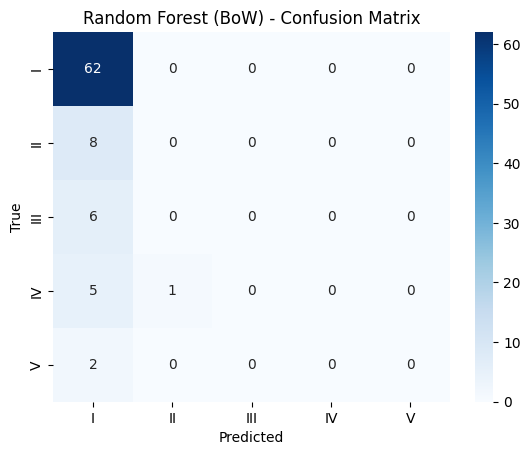

In [ ]:
# Evaluate Random Forest with Bag-of-Words (BoW) - No Oversampling
evaluate_and_log(rf_bow_plain, X_train, y_train, X_test, y_test, "Random Forest (BoW)", RESULTS)


Random Forest (TF-IDF) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



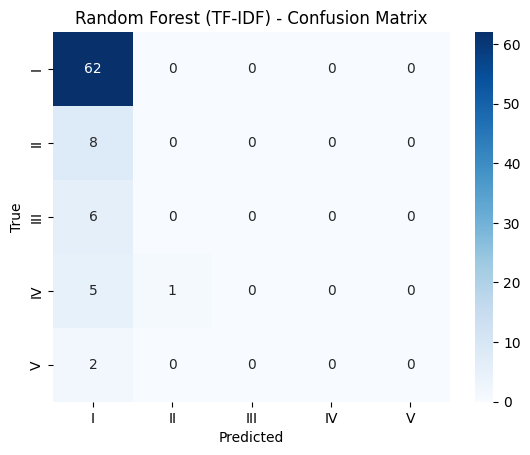

In [ ]:
# Evaluate Random Forest with TF-IDF - No Oversampling
evaluate_and_log(rf_tfidf_plain, X_train, y_train, X_test, y_test, "Random Forest (TF-IDF)", RESULTS)


Random Forest (BoW + Oversample) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.172

              precision    recall  f1-score   support

           I      0.756     1.000     0.861        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.151     0.200     0.172        84
weighted avg      0.558     0.738     0.636        84



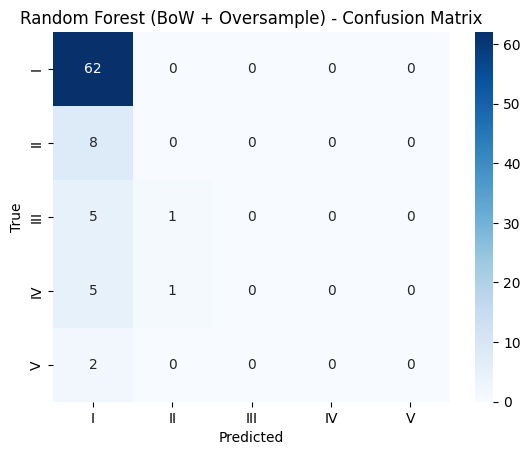

In [ ]:
# Evaluate Random Forest with BoW + Oversampling
evaluate_and_log(rf_bow_overs, X_train, y_train, X_test, y_test, "Random Forest (BoW + Oversample)", RESULTS)


Random Forest (TF-IDF + Oversample) Results
Train Accuracy: 0.994
Test  Accuracy: 0.726
Test  Macro-F1: 0.169

              precision    recall  f1-score   support

           I      0.744     0.984     0.847        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.726        84
   macro avg      0.149     0.197     0.169        84
weighted avg      0.549     0.726     0.625        84



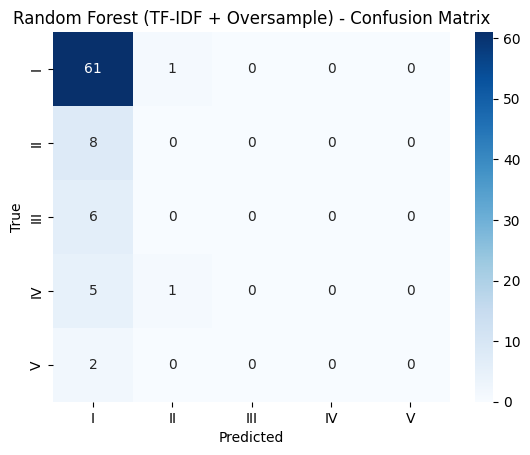

In [ ]:
# Evaluate Random Forest with TF-IDF + Oversampling
evaluate_and_log(rf_tfidf_overs, X_train, y_train, X_test, y_test, "Random Forest (TF-IDF + Oversample)", RESULTS)

#### Hyperparameter Tuning

In [ ]:
# Utility method to build Random Forest pipeline
def build_rf_pipeline(vectorizer):
    return ImbPipeline([
        (vectorizer.__class__.__name__.lower(), vectorizer),
        ("oversample", sampler),
        ("clf", RandomForestClassifier(
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])


In [ ]:
# Hyper Parameters to be tuned
rf_grid = {
  "clf__n_estimators": [100, 200, 300],
  "clf__max_depth": [None, 10, 20],
  "clf__min_samples_leaf": [1, 2, 4],
  "clf__max_features": ["sqrt", "log2"]
}

#### 1. Hyperparameter Tuning for Random Forest with BoW

In [ ]:
# Build Random Forest pipeline with BoW vectorization
pipe_rf_bow = build_rf_pipeline(bow_vectorizer)

# Set up GridSearchCV for Random Forest with BoW
grid_rf_bow = GridSearchCV(
    estimator=pipe_rf_bow,
    param_grid=rf_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score="raise"
)

# Run the grid search on the training data
grid_rf_bow.fit(X_train, y_train)

print("Best BoW params:", grid_rf_bow.best_params_, "CV Macro-F1:", round(grid_rf_bow.best_score_, 3))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best BoW params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200} CV Macro-F1: 0.731


#### 2. Hyperparameter Tuning for Random Forest with TF-IDF

In [ ]:
# Build Random Forest pipeline with TF-IDF vectorization
pipe_rf_tfidf = build_rf_pipeline(tfidf_vectorizer)

# Set up GridSearchCV for Random Forest with TF-IDF
grid_rf_tfidf = GridSearchCV(
    estimator=pipe_rf_tfidf,
    param_grid=rf_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score="raise"
)


# Run the grid search on the training data
grid_rf_tfidf.fit(X_train, y_train)

print("Best BoW params:", grid_rf_tfidf.best_params_, "CV Macro-F1:", round(grid_rf_tfidf.best_score_, 3))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best BoW params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200} CV Macro-F1: 0.731


#### Tuned Model Evaluation


Random Forest (BoW + TUNED) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.172

              precision    recall  f1-score   support

           I      0.756     1.000     0.861        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.151     0.200     0.172        84
weighted avg      0.558     0.738     0.636        84



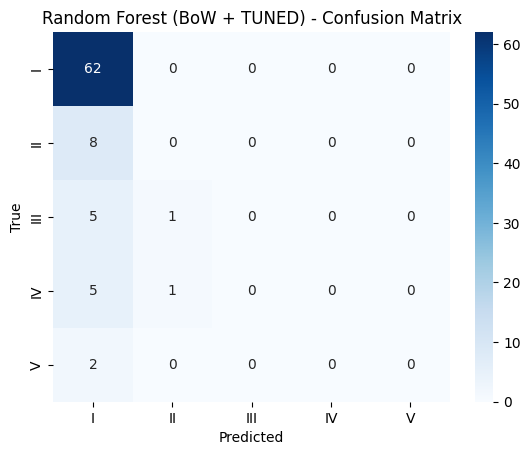

In [ ]:
#Evaluate Random Forest with BOW + Tuned
evaluate_and_log(grid_rf_bow.best_estimator_,   X_train, y_train, X_test, y_test,
                     "Random Forest (BoW + TUNED)", RESULTS)


Random Forest (TF-IDF + TUNED) Results
Train Accuracy: 0.994
Test  Accuracy: 0.738
Test  Macro-F1: 0.171

              precision    recall  f1-score   support

           I      0.747     1.000     0.855        62
          II      0.000     0.000     0.000         8
         III      0.000     0.000     0.000         6
          IV      0.000     0.000     0.000         6
           V      0.000     0.000     0.000         2

    accuracy                          0.738        84
   macro avg      0.149     0.200     0.171        84
weighted avg      0.551     0.738     0.631        84



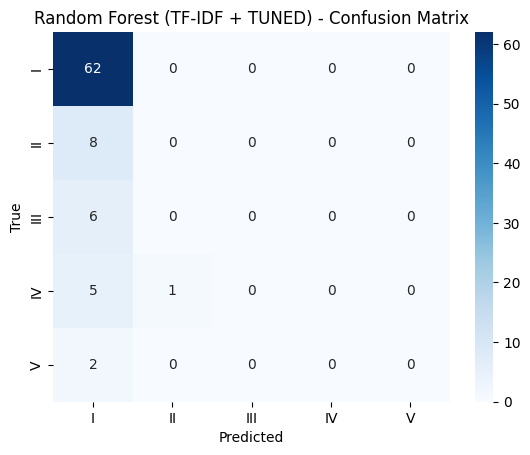

In [ ]:
#Evaluate Random Forest with TF-IDF + Tuned
evaluate_and_log(grid_rf_tfidf.best_estimator_,   X_train, y_train, X_test, y_test,
                     "Random Forest (TF-IDF + TUNED)", RESULTS)

XGBoost  model

In [ ]:
# import xgboost
import xgboost as xgb

In [ ]:
# creating Bag of Words
bow_vectorizer = CountVectorizer()
bow = bow_vectorizer.fit_transform(data['final_cleaned_text'])
bow_df = pd.DataFrame(bow.toarray(), columns=bow_vectorizer.get_feature_names_out())
bow_df.index = data.index
bow_df.head()

,00,001,007,01,018,0183,02,020,02bp0166,02bp0167,...,young,z014,zaf,zamac,zaro,zero,zinc,zinco,zn,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# creating tf-idf
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(data['final_cleaned_text'])
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.index = data.index
tfidf_df.head()

,00,001,007,01,018,0183,02,020,02bp0166,02bp0167,...,young,z014,zaf,zamac,zaro,zero,zinc,zinco,zn,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.185663,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Train Test Split for BoW
X = bow_df
y = data['Accident Level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# train XG Boost classifier on BoW
from sklearn.preprocessing import LabelEncoder
# Create and fit label encoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Train XGBoost with encoded labels
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train_encoded)

# Make predictions and decode them back to original labels
y_pred_encoded = xgb_classifier.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)

XGboost_BoW_accuracy=accuracy_score(y_test, y_pred)
print("\nAccuracy Score:", XGboost_BoW_accuracy)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:50:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Accuracy Score: 0.7142857142857143


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:51:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost (BoW) Results
Train Accuracy: 0.994
Test  Accuracy: 0.714
Test  Macro-F1: 0.170

              precision    recall  f1-score   support

           0      0.759     0.968     0.851        62
           1      0.000     0.000     0.000         8
           2      0.000     0.000     0.000         6
           3      0.000     0.000     0.000         6
           4      0.000     0.000     0.000         2

    accuracy                          0.714        84
   macro avg      0.152     0.194     0.170        84
weighted avg      0.561     0.714     0.628        84



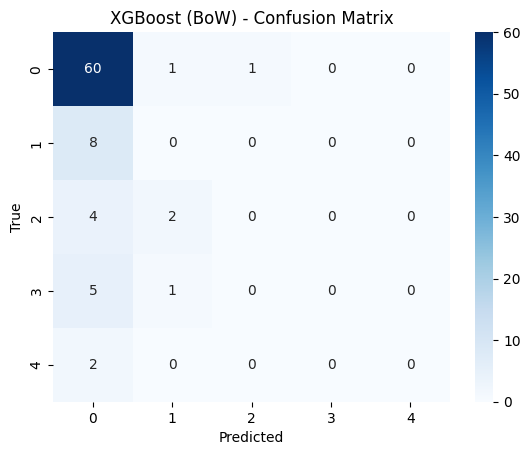

In [ ]:
#Evaluate XGBoost with BoW
evaluate_and_log(xgb_classifier, X_train, y_train_encoded, X_test, y_test_encoded,
                     "XGBoost (BoW)", RESULTS)

In [ ]:
# Train Test Split for tfidf

X = tfidf_df
y = data['Accident Level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# train XG Boost classifier on TF-IDF

# Create and fit label encoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Train XGBoost with encoded labels
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train_encoded)

# Make predictions and decode them back to original labels
y_pred_encoded = xgb_classifier.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)

XGboost_TFIDF_accuracy=accuracy_score(y_test, y_pred)
# Print metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred,zero_division=0))
print("\nAccuracy Score:", XGboost_TFIDF_accuracy)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:51:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[58  4  0  0  0]
 [ 8  0  0  0  0]
 [ 5  1  0  0  0]
 [ 4  2  0  0  0]
 [ 2  0  0  0  0]]

Classification Report:
               precision    recall  f1-score   support

           I       0.75      0.94      0.83        62
          II       0.00      0.00      0.00         8
         III       0.00      0.00      0.00         6
          IV       0.00      0.00      0.00         6
           V       0.00      0.00      0.00         2

    accuracy                           0.69        84
   macro avg       0.15      0.19      0.17        84
weighted avg       0.56      0.69      0.62        84


Accuracy Score: 0.6904761904761905


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:51:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost (TF-IDF) Results
Train Accuracy: 0.997
Test  Accuracy: 0.690
Test  Macro-F1: 0.167

              precision    recall  f1-score   support

           0      0.753     0.935     0.835        62
           1      0.000     0.000     0.000         8
           2      0.000     0.000     0.000         6
           3      0.000     0.000     0.000         6
           4      0.000     0.000     0.000         2

    accuracy                          0.690        84
   macro avg      0.151     0.187     0.167        84
weighted avg      0.556     0.690     0.616        84



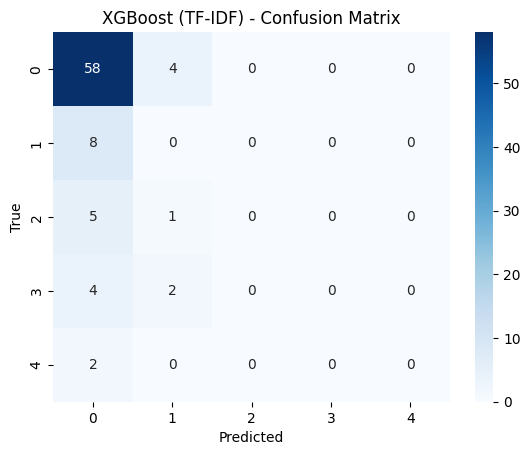

In [ ]:
#Evaluate XGBoost with BoW
evaluate_and_log(xgb_classifier, X_train, y_train_encoded, X_test, y_test_encoded,
                     "XGBoost (TF-IDF)", RESULTS)

In [ ]:
pd.DataFrame(RESULTS).sort_values("Test Accuracy", ascending=False)

,Model,Train Accuracy,Test Accuracy,Test Macro-F1
0,AdaBoost (BoW),0.746,0.738,0.170
1,AdaBoost (TF-IDF),0.746,0.738,0.170
9,SVM (TF-IDF + Oversample),0.991,0.738,0.171
8,SVM (BoW + Oversample),0.958,0.738,0.170
7,SVM (TF-IDF),0.991,0.738,0.171
6,SVM (BoW),0.850,0.738,0.170
14,Random Forest (BoW),0.994,0.738,0.171
15,Random Forest (TF-IDF),0.994,0.738,0.171
16,Random Forest (BoW + Oversample),0.994,0.738,0.172
18,Random Forest (BoW + TUNED),0.994,0.738,0.172
